# Explainability for classification-trained Lindsey encoder

In [1]:
# # general libraries
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

# explainability
from captum.attr import Saliency, GuidedBackprop, Occlusion

# # custom/special libraries

from retinal_rl.system.encoders import LindseyEncoderBase
from retinal_rl.helpers import get_cfg_jupyter
from retinal_rl.system.environment import register_retinal_environment
from retinal_rl.system.encoders import register_encoders
from retinal_rl.analysis.util import pad_dataset
from retinal_rl.analysis.statistics import spike_triggered_average

from sample_factory.envs.create_env import create_env
from sample_factory.utils.utils import log, AttrDict
from sample_factory.utils.timing import Timing

from retinal_rl.analysis.util import get_padded_mnist, LindseyClassificationEncoder
from retinal_rl.analysis.plot import plot_example_stim_torch, plot_att_action
# automatic reloading
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

path = os.path.dirname(os.getcwd() + '/')
dirname = os.path.basename(path)
if dirname != 'retinal-rl':
    os.chdir('..')

/gpfs01/berens/user/jmajnik/miniconda3/envs/reg_retinal-rl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda:0


# Defining custom dataset and model classes

# Extracting some parameters

In [2]:
experiment = 'postcosyne_complicated_appmnist-mnist_01' # this can be more or less whichever, just to get cfg and env!
class_model_name = 'mnist_class_100epoch20221207_002320'# this is the path to a saved classification model, trained and exported using 'dev_jm_lindsey_MNIST_classification.ipynb', saved as a '.npy' in 'pytorch/models/'
analyze_ds_name = 'MNIST'

In [3]:
register_retinal_environment()
register_encoders()
cfg = get_cfg_jupyter(experiment) # this is not needed in script
cfg.analyze_ds_name = analyze_ds_name

# creating env to get appropriate 
env = create_env(cfg.env, cfg=cfg, env_config=AttrDict({'worker_index': 0, 'vector_index': 0}))

[2022-12-23 21:08:53,093][49771] Default env families supported: ['doom_*', 'atari_*', 'dmlab_*', 'mujoco_*', 'MiniGrid*']
[2022-12-23 21:08:53,096][49771] Env registry entry created: retinal_
[2022-12-23 21:08:53,097][49771] Adding model class <class 'retinal_rl.system.encoders.LindseyEncoder'> to registry (with name lindsey)
[2022-12-23 21:08:53,197][49771] Doom resolution: 160x120, resize resolution: (120, 90)


--env=retinal_appmnist_apples_gathering_01
--vvs_depth=1
--algo=APPO
--experiment=postcosyne_complicated_appmnist-mnist_01
--global_channels=16
--retinal_bottleneck=4
--analyze_acts=False
--res_h=90
--res_w=120


# Making padded dataset and preparing data

In [4]:
padded_ds = get_padded_mnist(cfg) # this has optional scaling and offset arguments

tcmalloc: large alloc 7776002048 bytes == 0x5573e1f70000 @ 


## Plotting RFs from loaded model

In [5]:
model = np.load(f'pytorch/models/{class_model_name}.npy', allow_pickle=True).item()

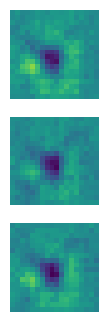

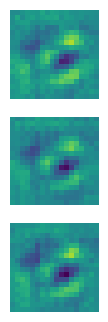

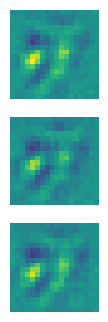

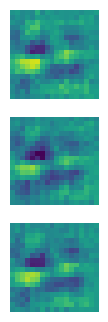

In [6]:
lay = 2
rds = 2 + (8*(lay-1) + model.kernel_size) // 2
isz = [3, 90, 120] # C, H, W
flt = 1

enc = model.base_encoder

with torch.no_grad():
    for flt in range(4):
        avg = spike_triggered_average(device,enc,lay,flt,rds,isz)
        vmax = abs(avg).max()

        fig, axs = plt.subplots(3, 1, dpi=100)
        for i in range(avg.shape[0]):
            axs[i].imshow(avg[i,:,:], vmin=-vmax, vmax=vmax)
            axs[i].axis('off')
            
        plt.show()

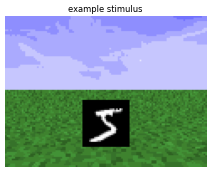

In [7]:
plot_example_stim_torch(padded_ds[0][0])

## Applying explainability techniques

In [8]:
model.eval()
model.to(device)

LindseyClassificationEncoder(
  (activation): ELU(alpha=1.0, inplace=True)
  (nl_fc): ELU(alpha=1.0, inplace=True)
  (conv_head): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d(16, 4, kernel_size=(7, 7), stride=(1, 1))
    (3): ELU(alpha=1.0, inplace=True)
    (4): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1))
    (5): ELU(alpha=1.0, inplace=True)
  )
  (fc1): Linear(in_features=21600, out_features=64, bias=True)
  (base_encoder): LindseyEncoderBase(
    (activation): ELU(alpha=1.0, inplace=True)
    (nl_fc): ELU(alpha=1.0, inplace=True)
    (conv_head): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
      (1): ELU(alpha=1.0, inplace=True)
      (2): Conv2d(16, 4, kernel_size=(7, 7), stride=(1, 1))
      (3): ELU(alpha=1.0, inplace=True)
      (4): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1))
      (5): ELU(alpha=1.0, inplace=True)
    )
    (fc1): Linear(in_features=21600, out_

In [9]:
gbp = GuidedBackprop(model)

/gpfs01/berens/user/jmajnik/miniconda3/envs/reg_retinal-rl/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/gpfs01/berens/user/jmajnik/miniconda3/envs/reg_retinal-rl/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


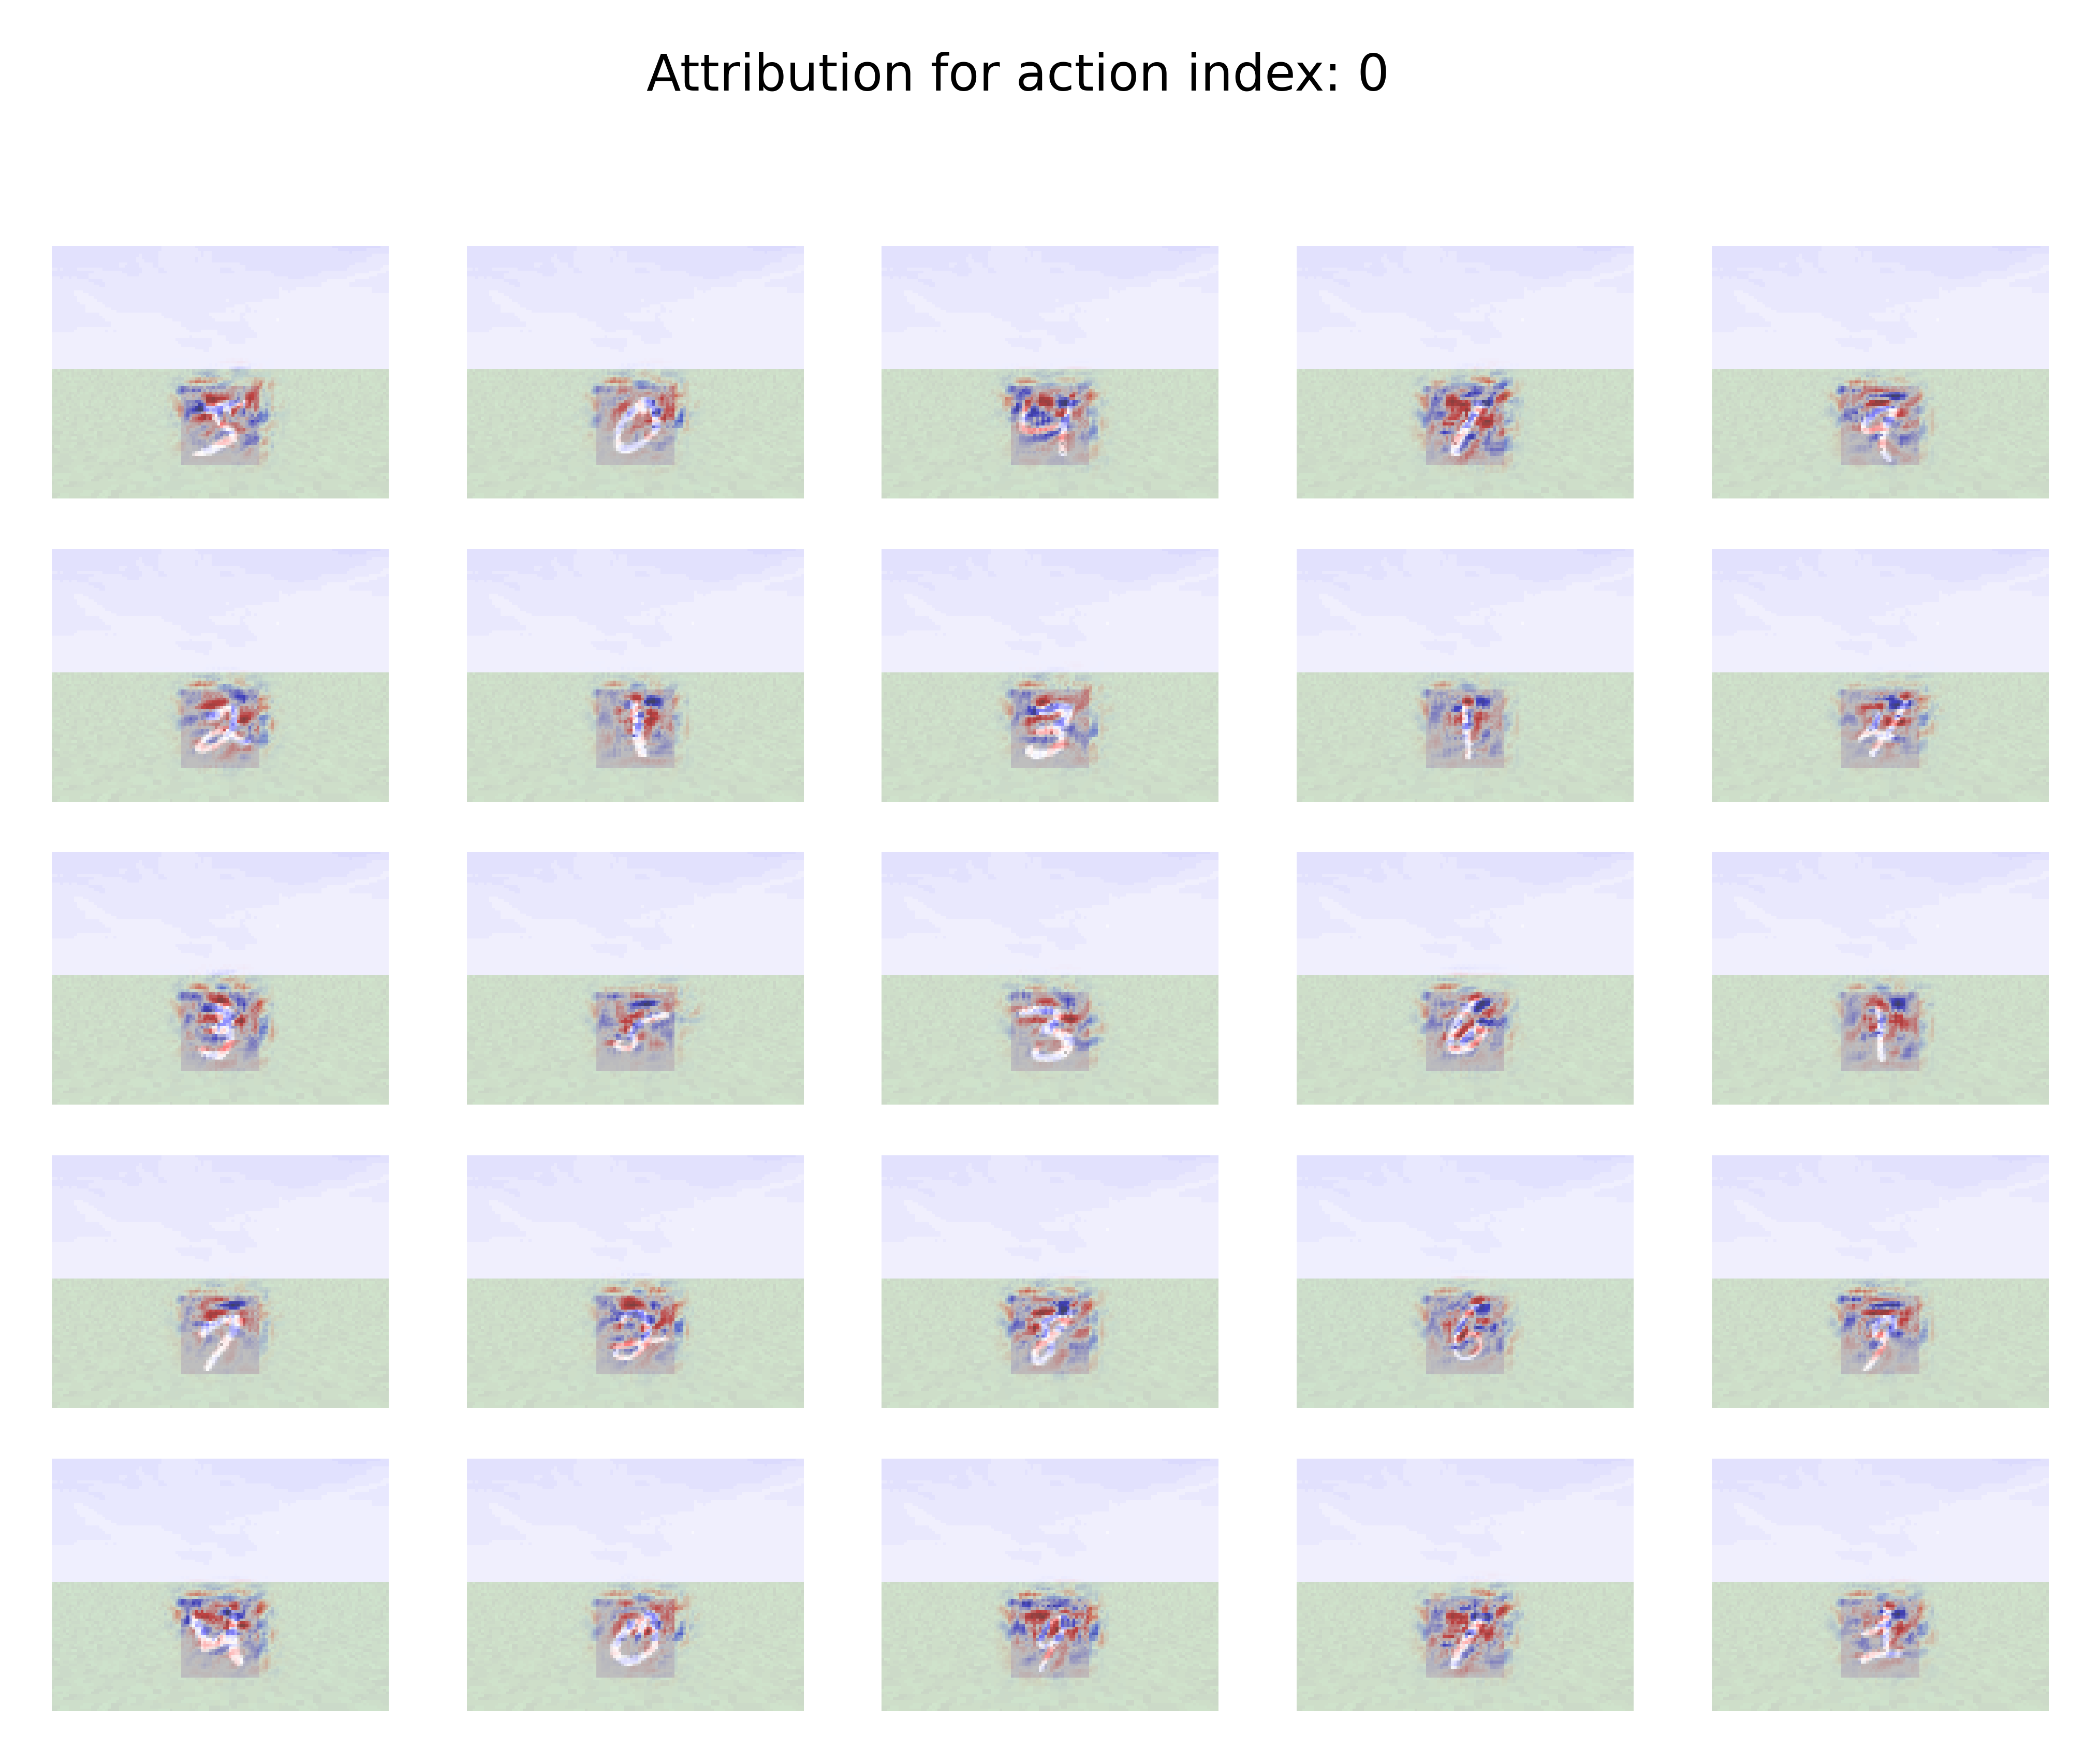

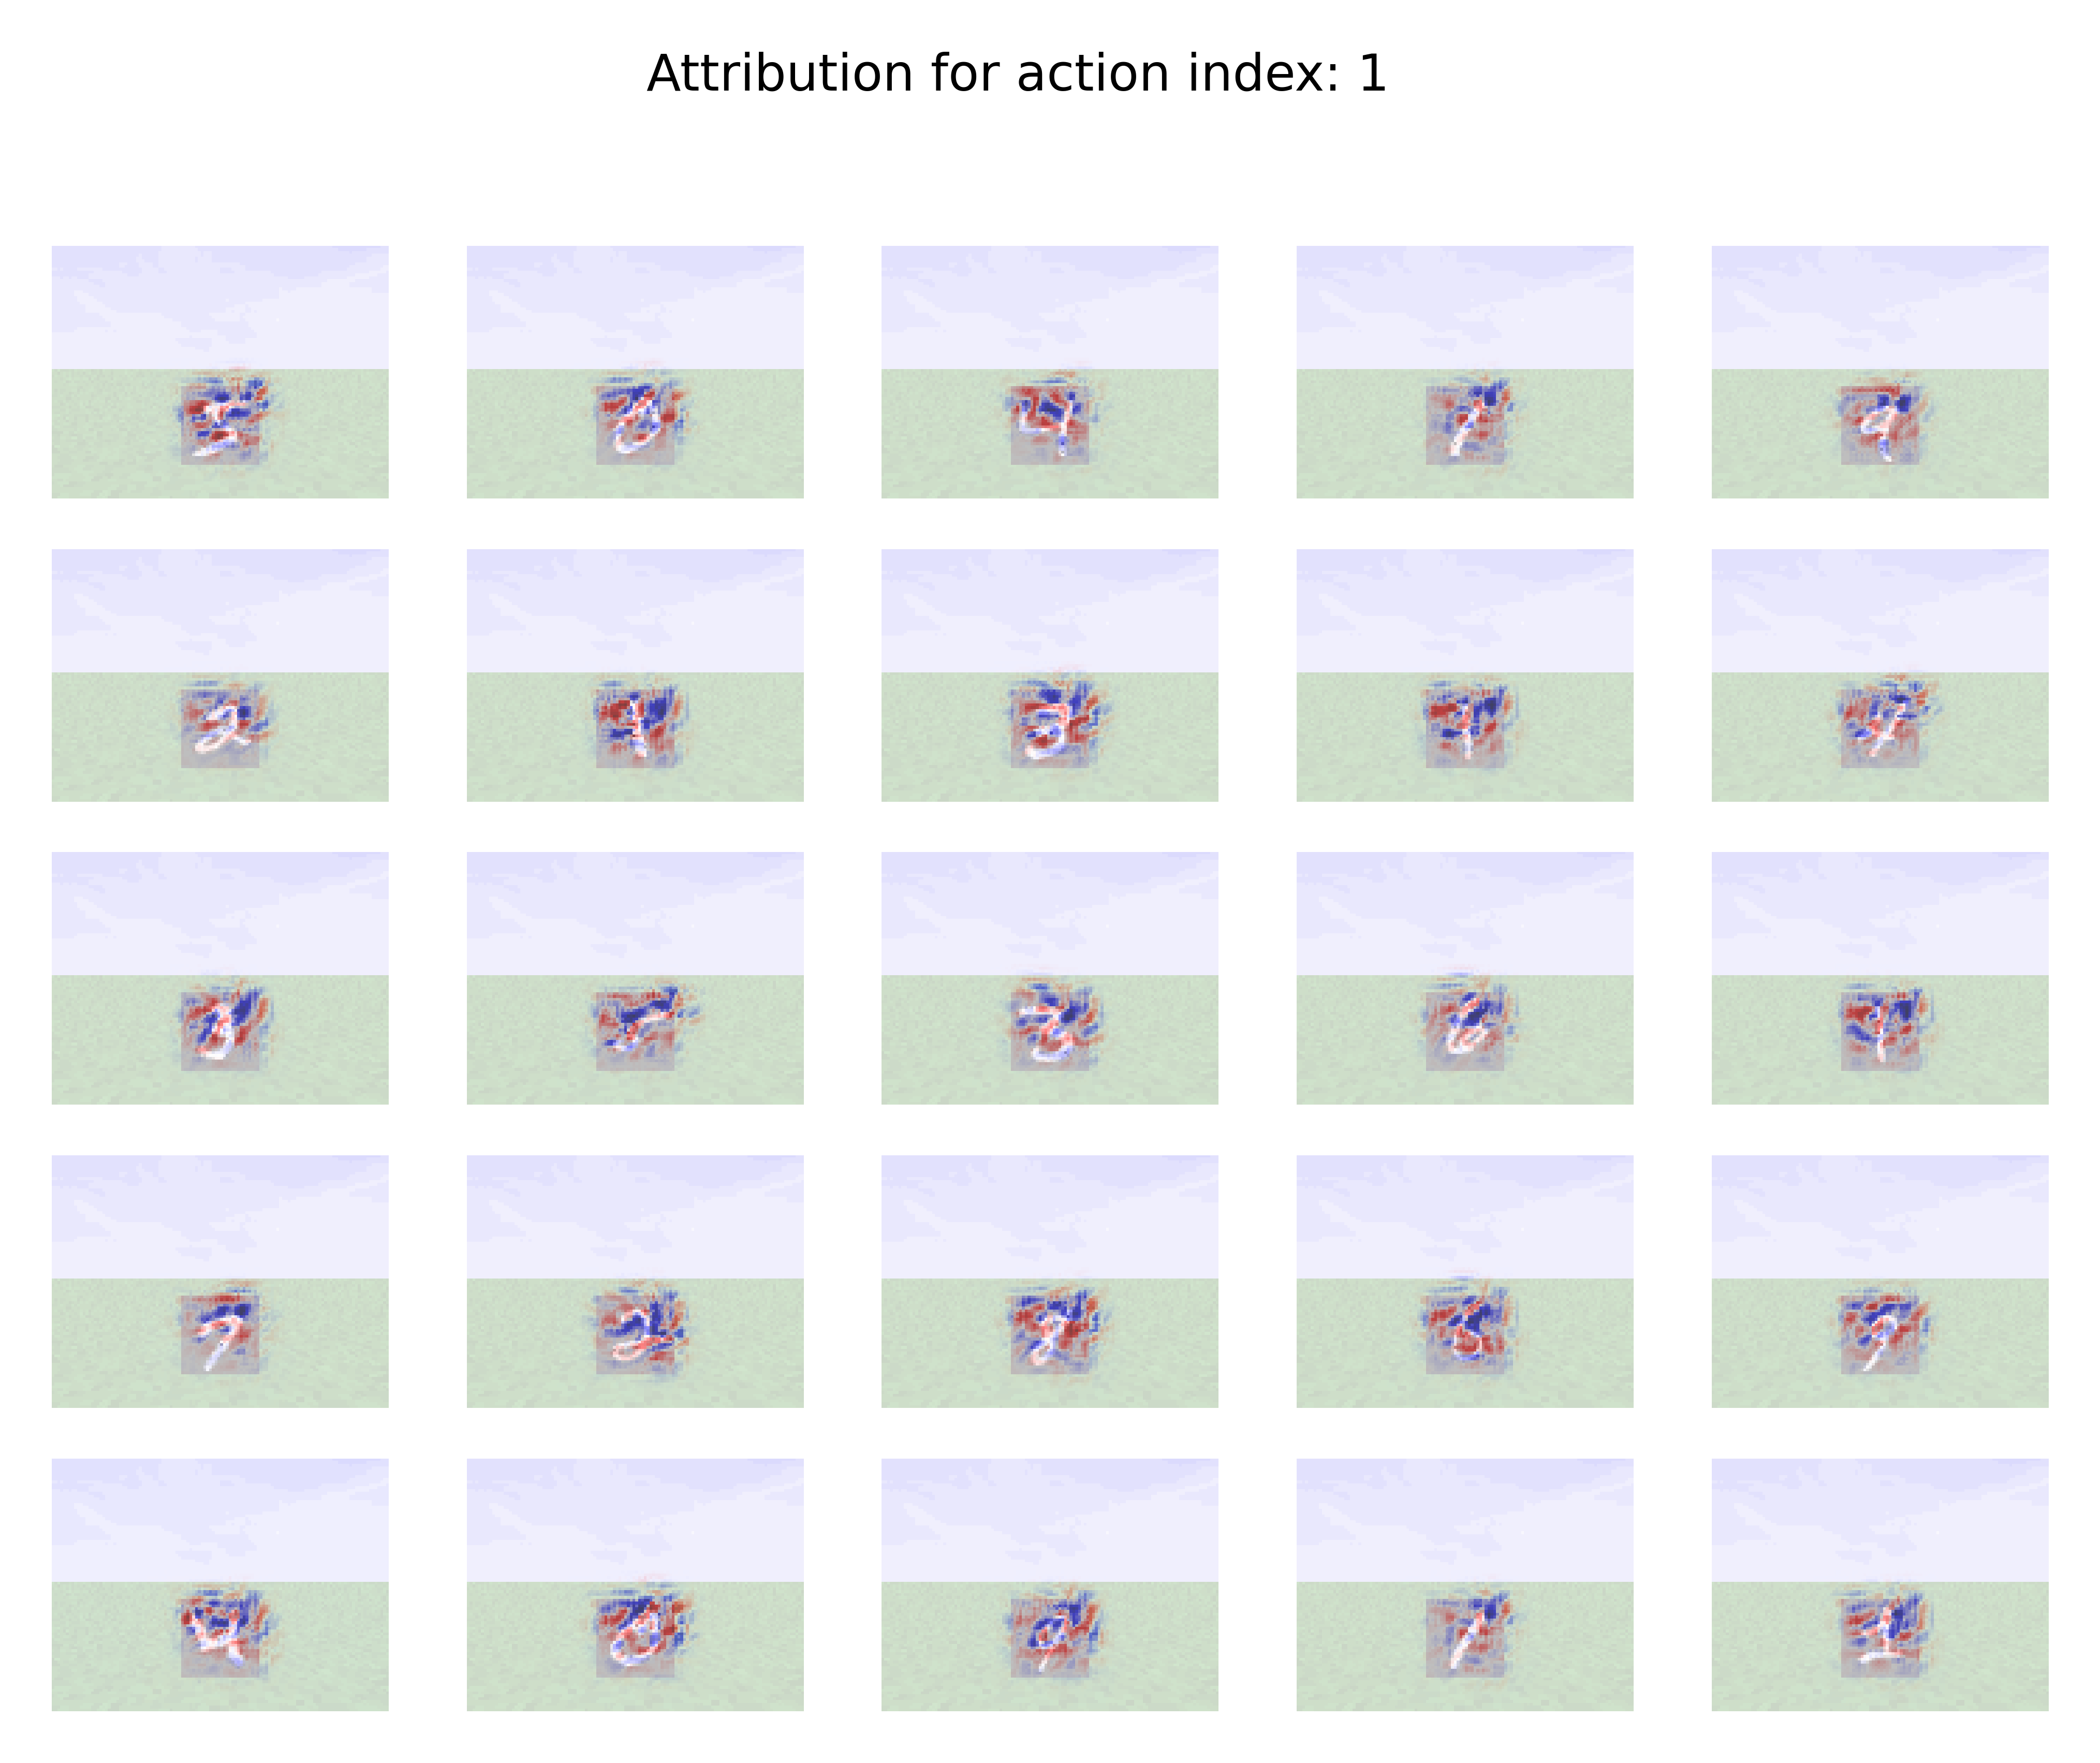

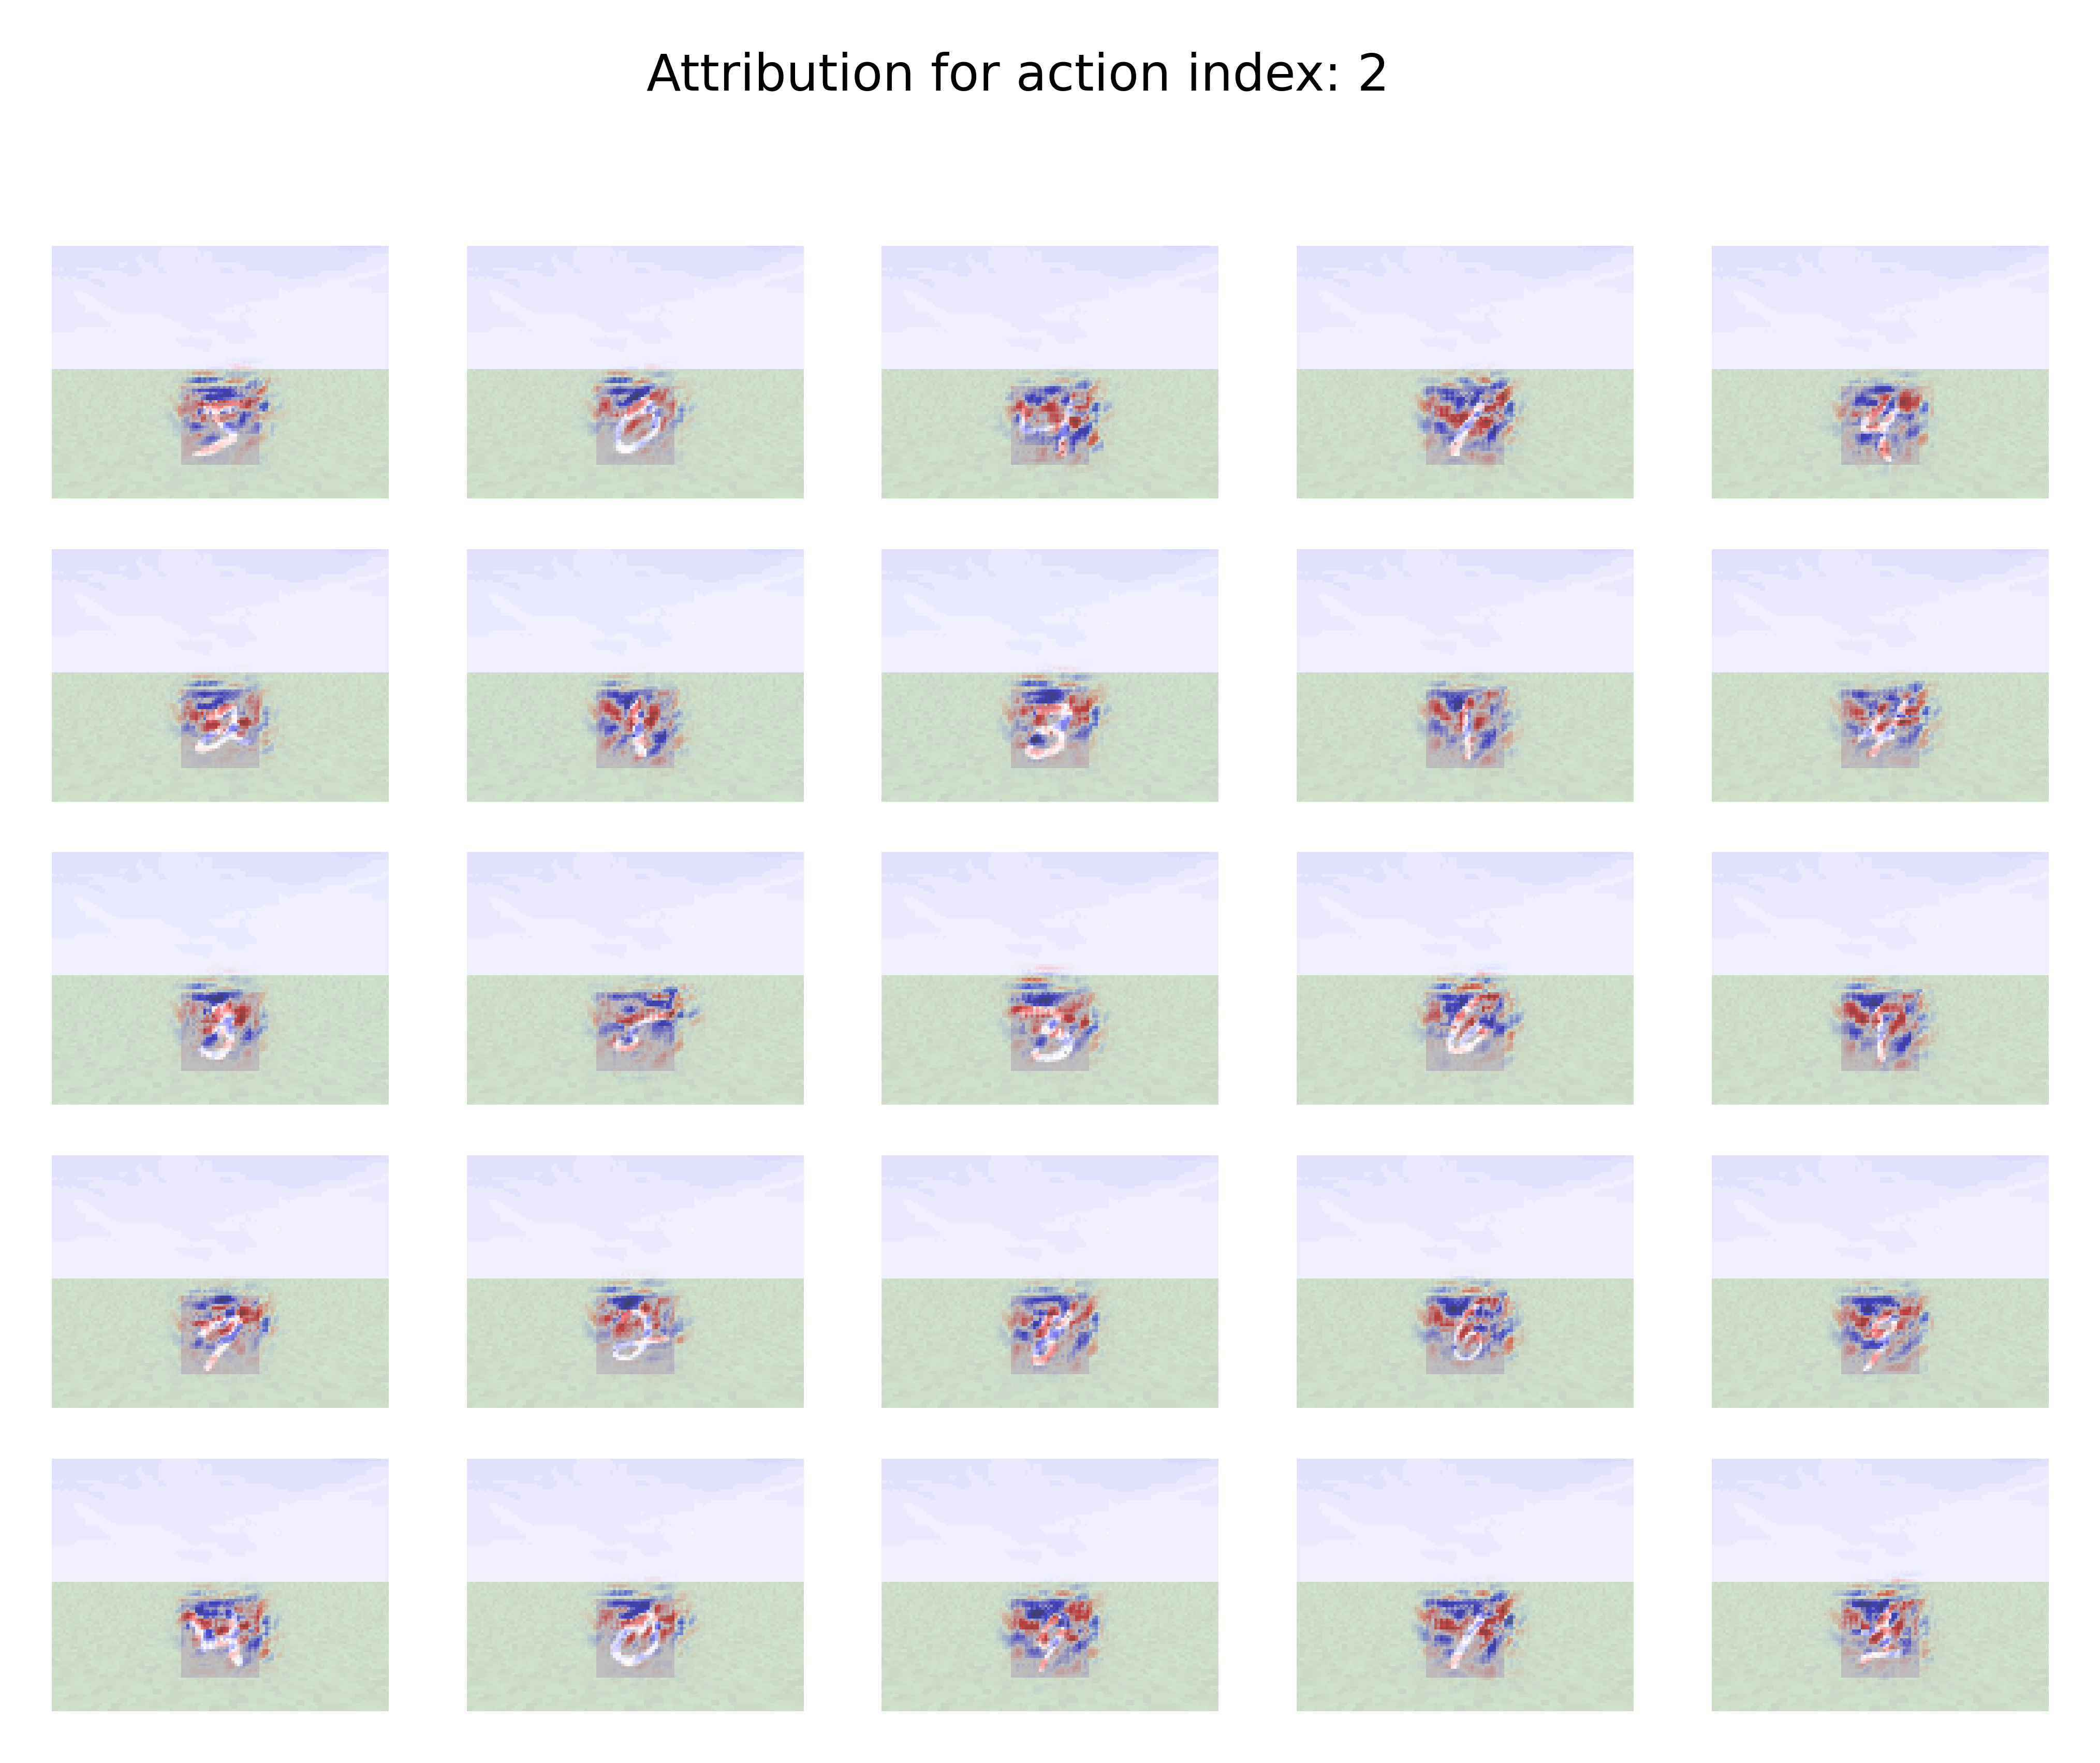

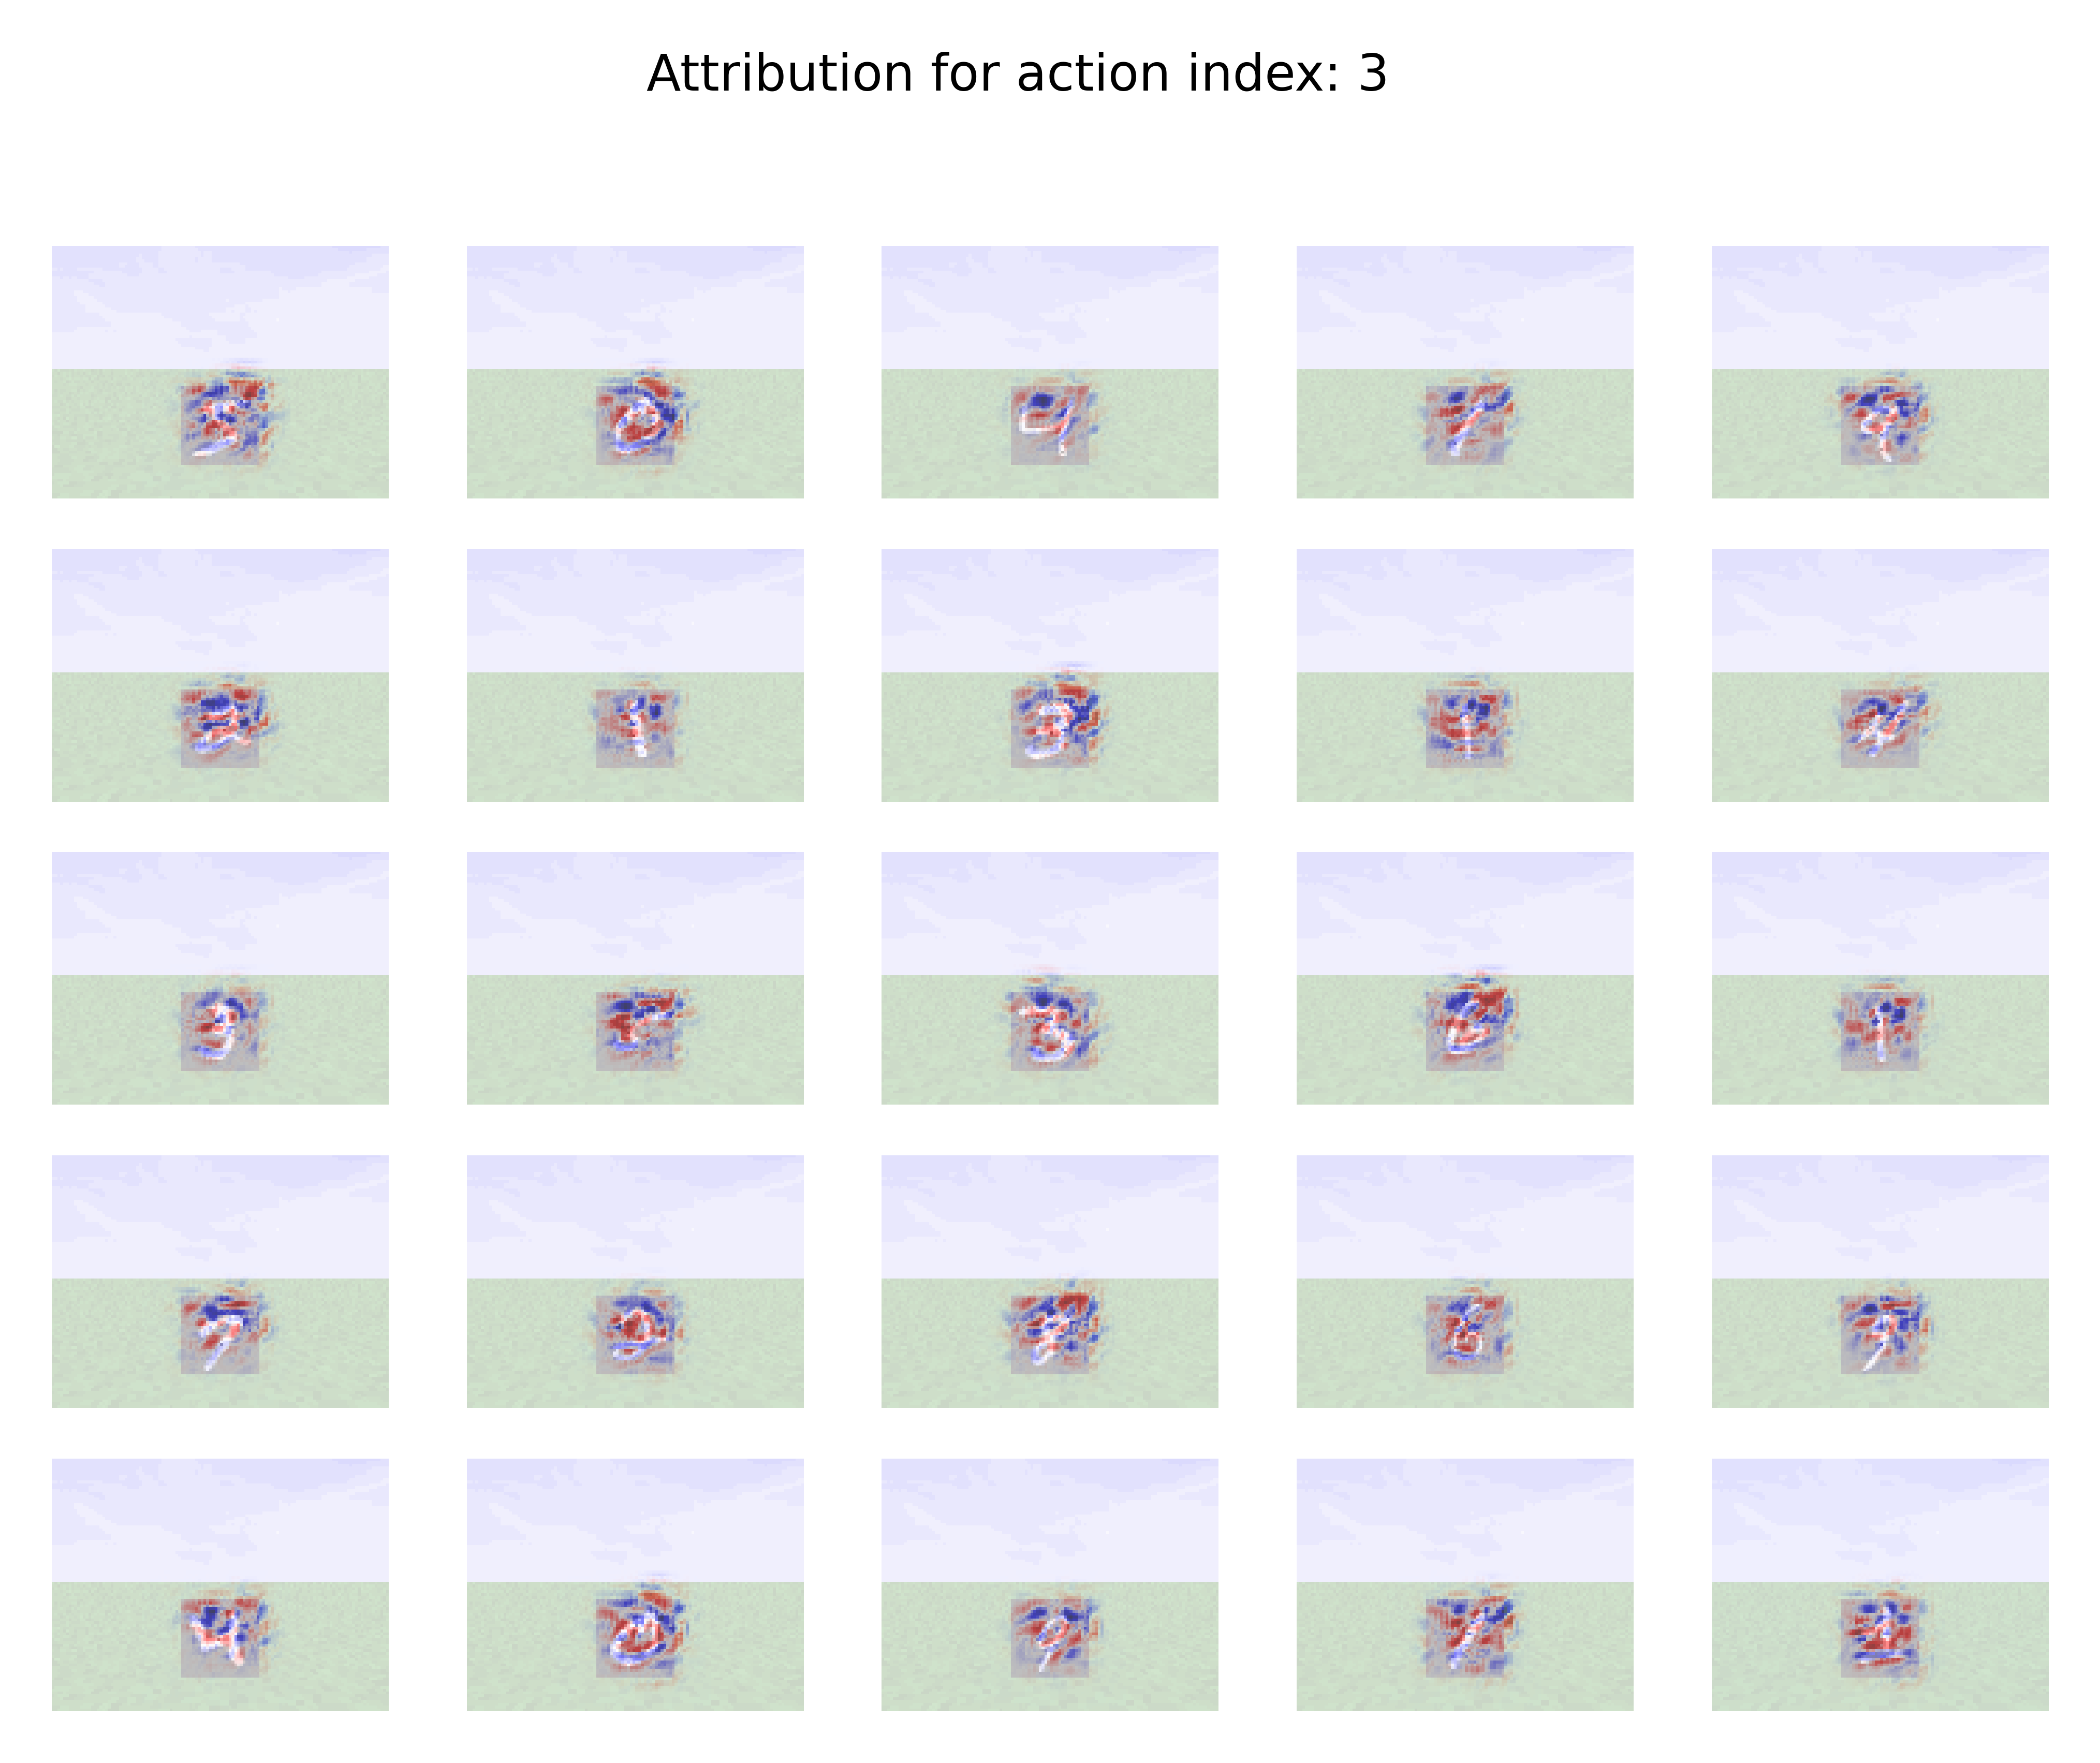

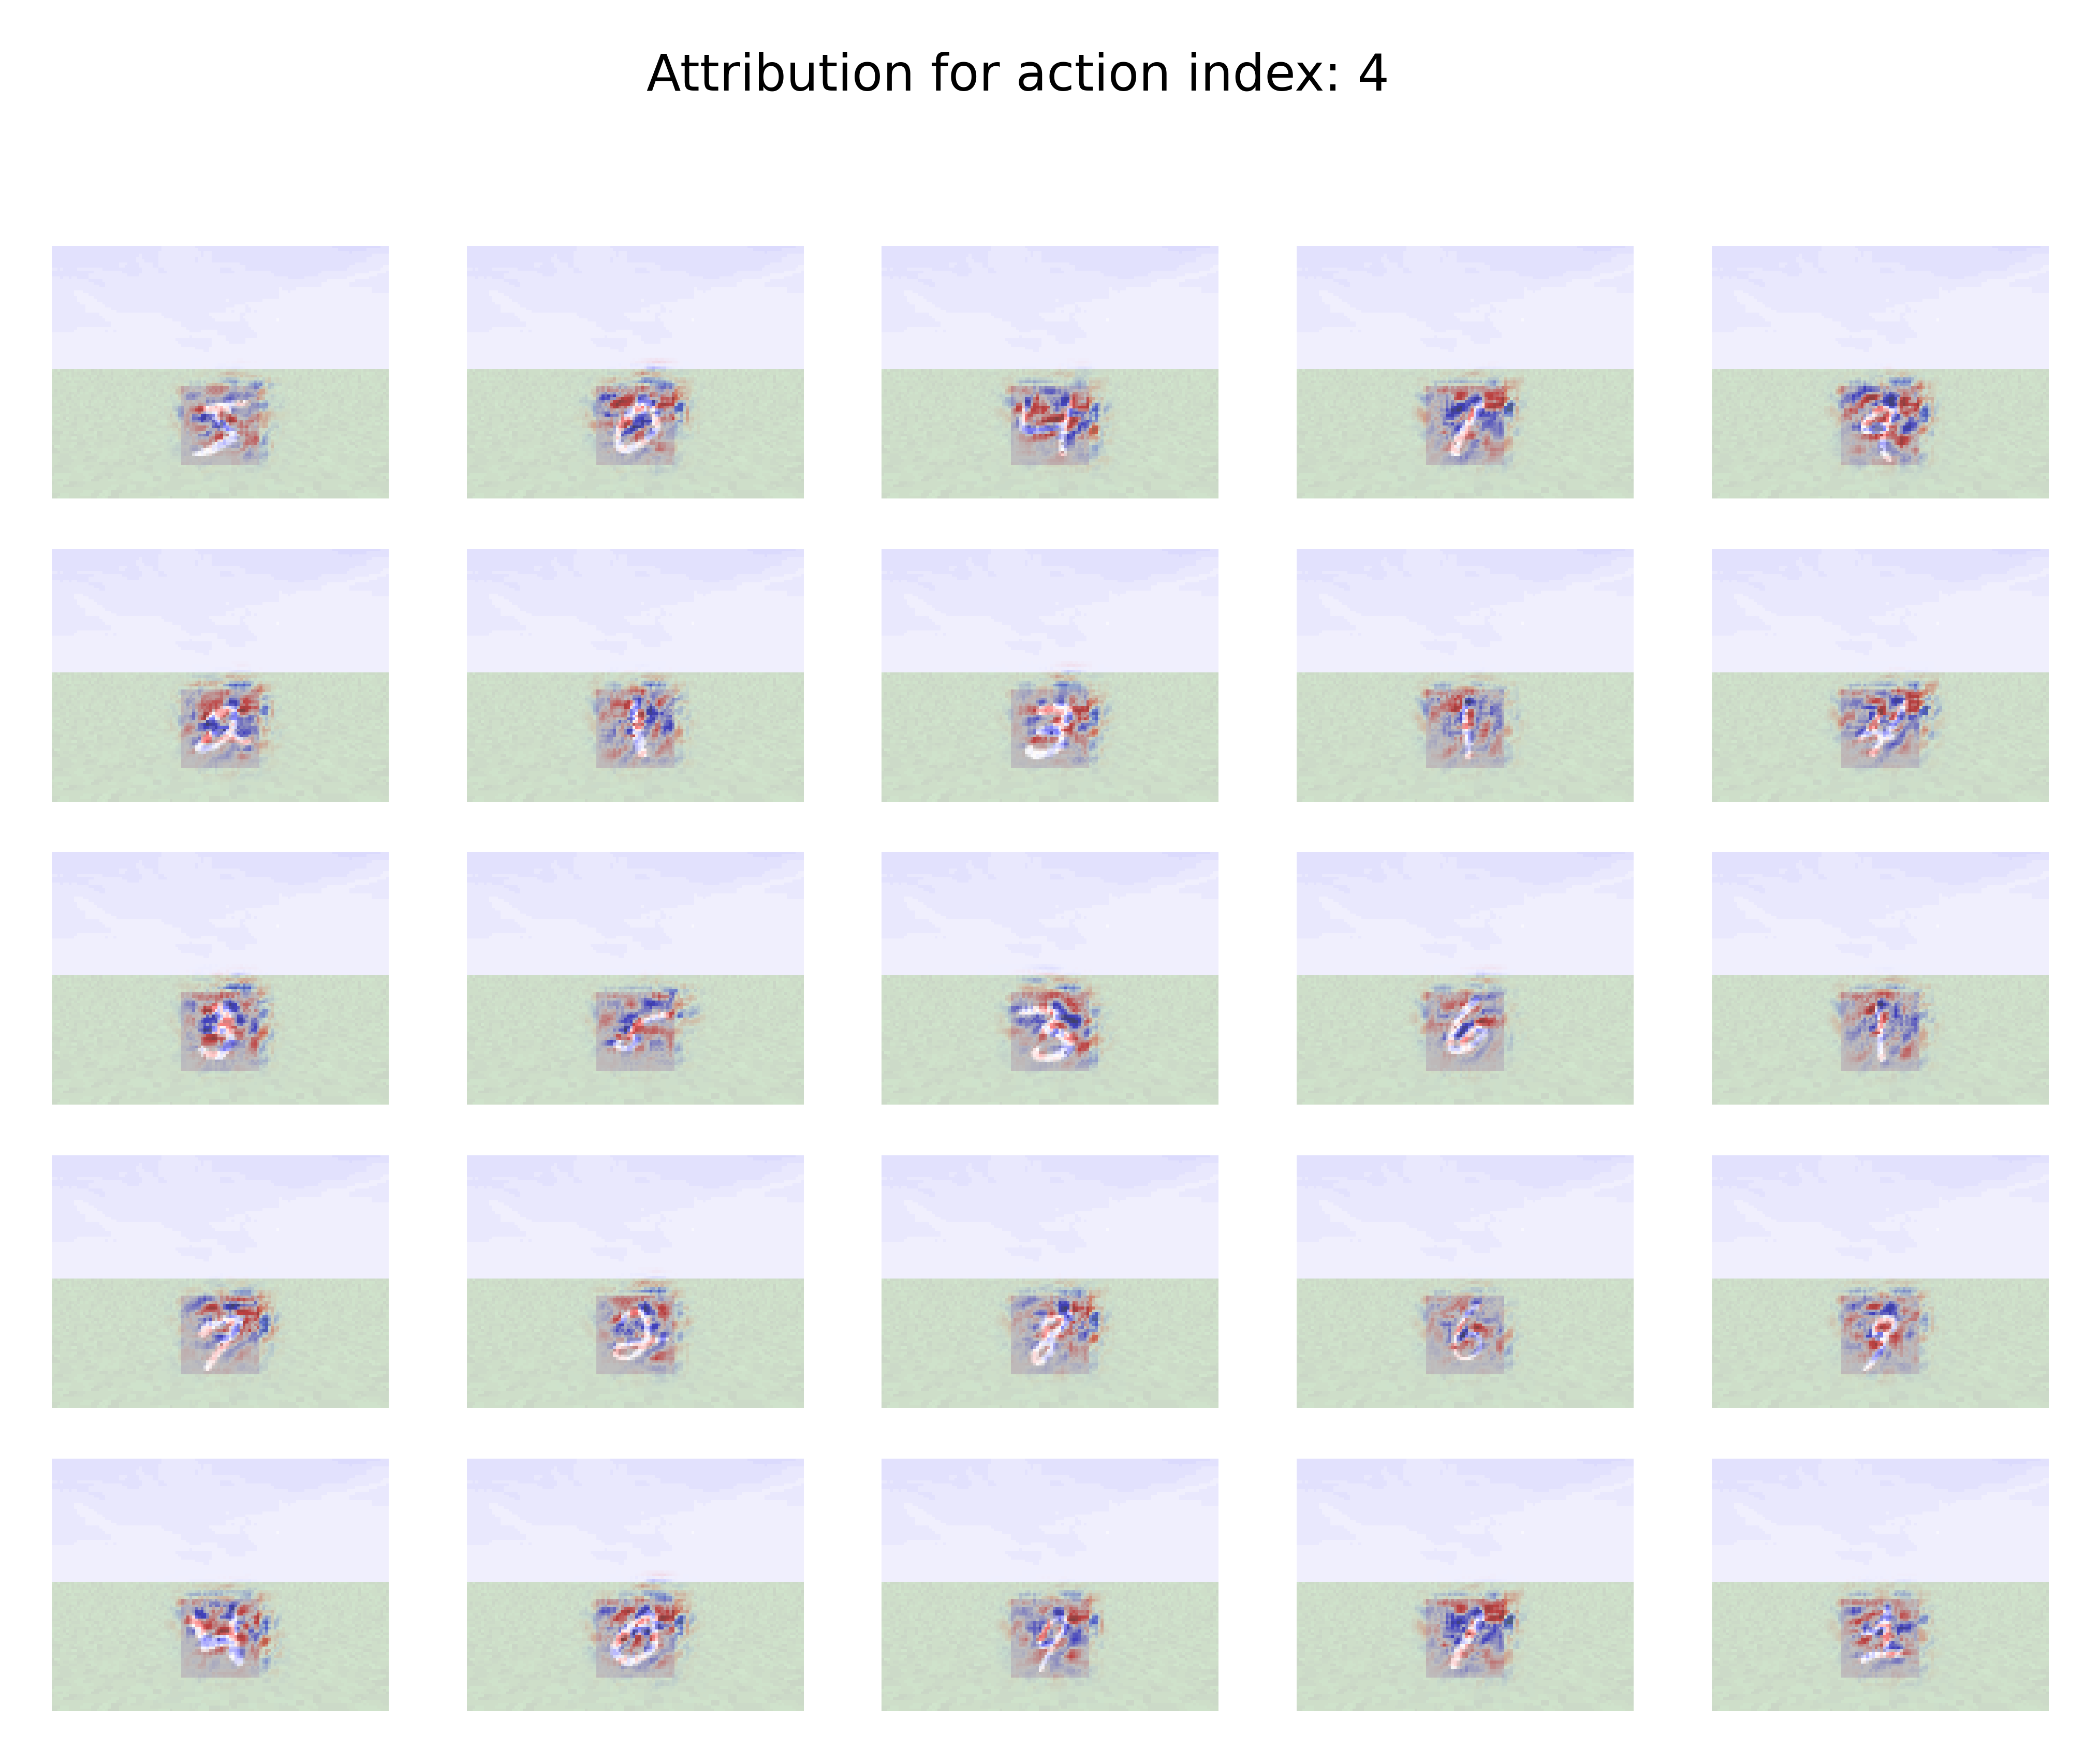

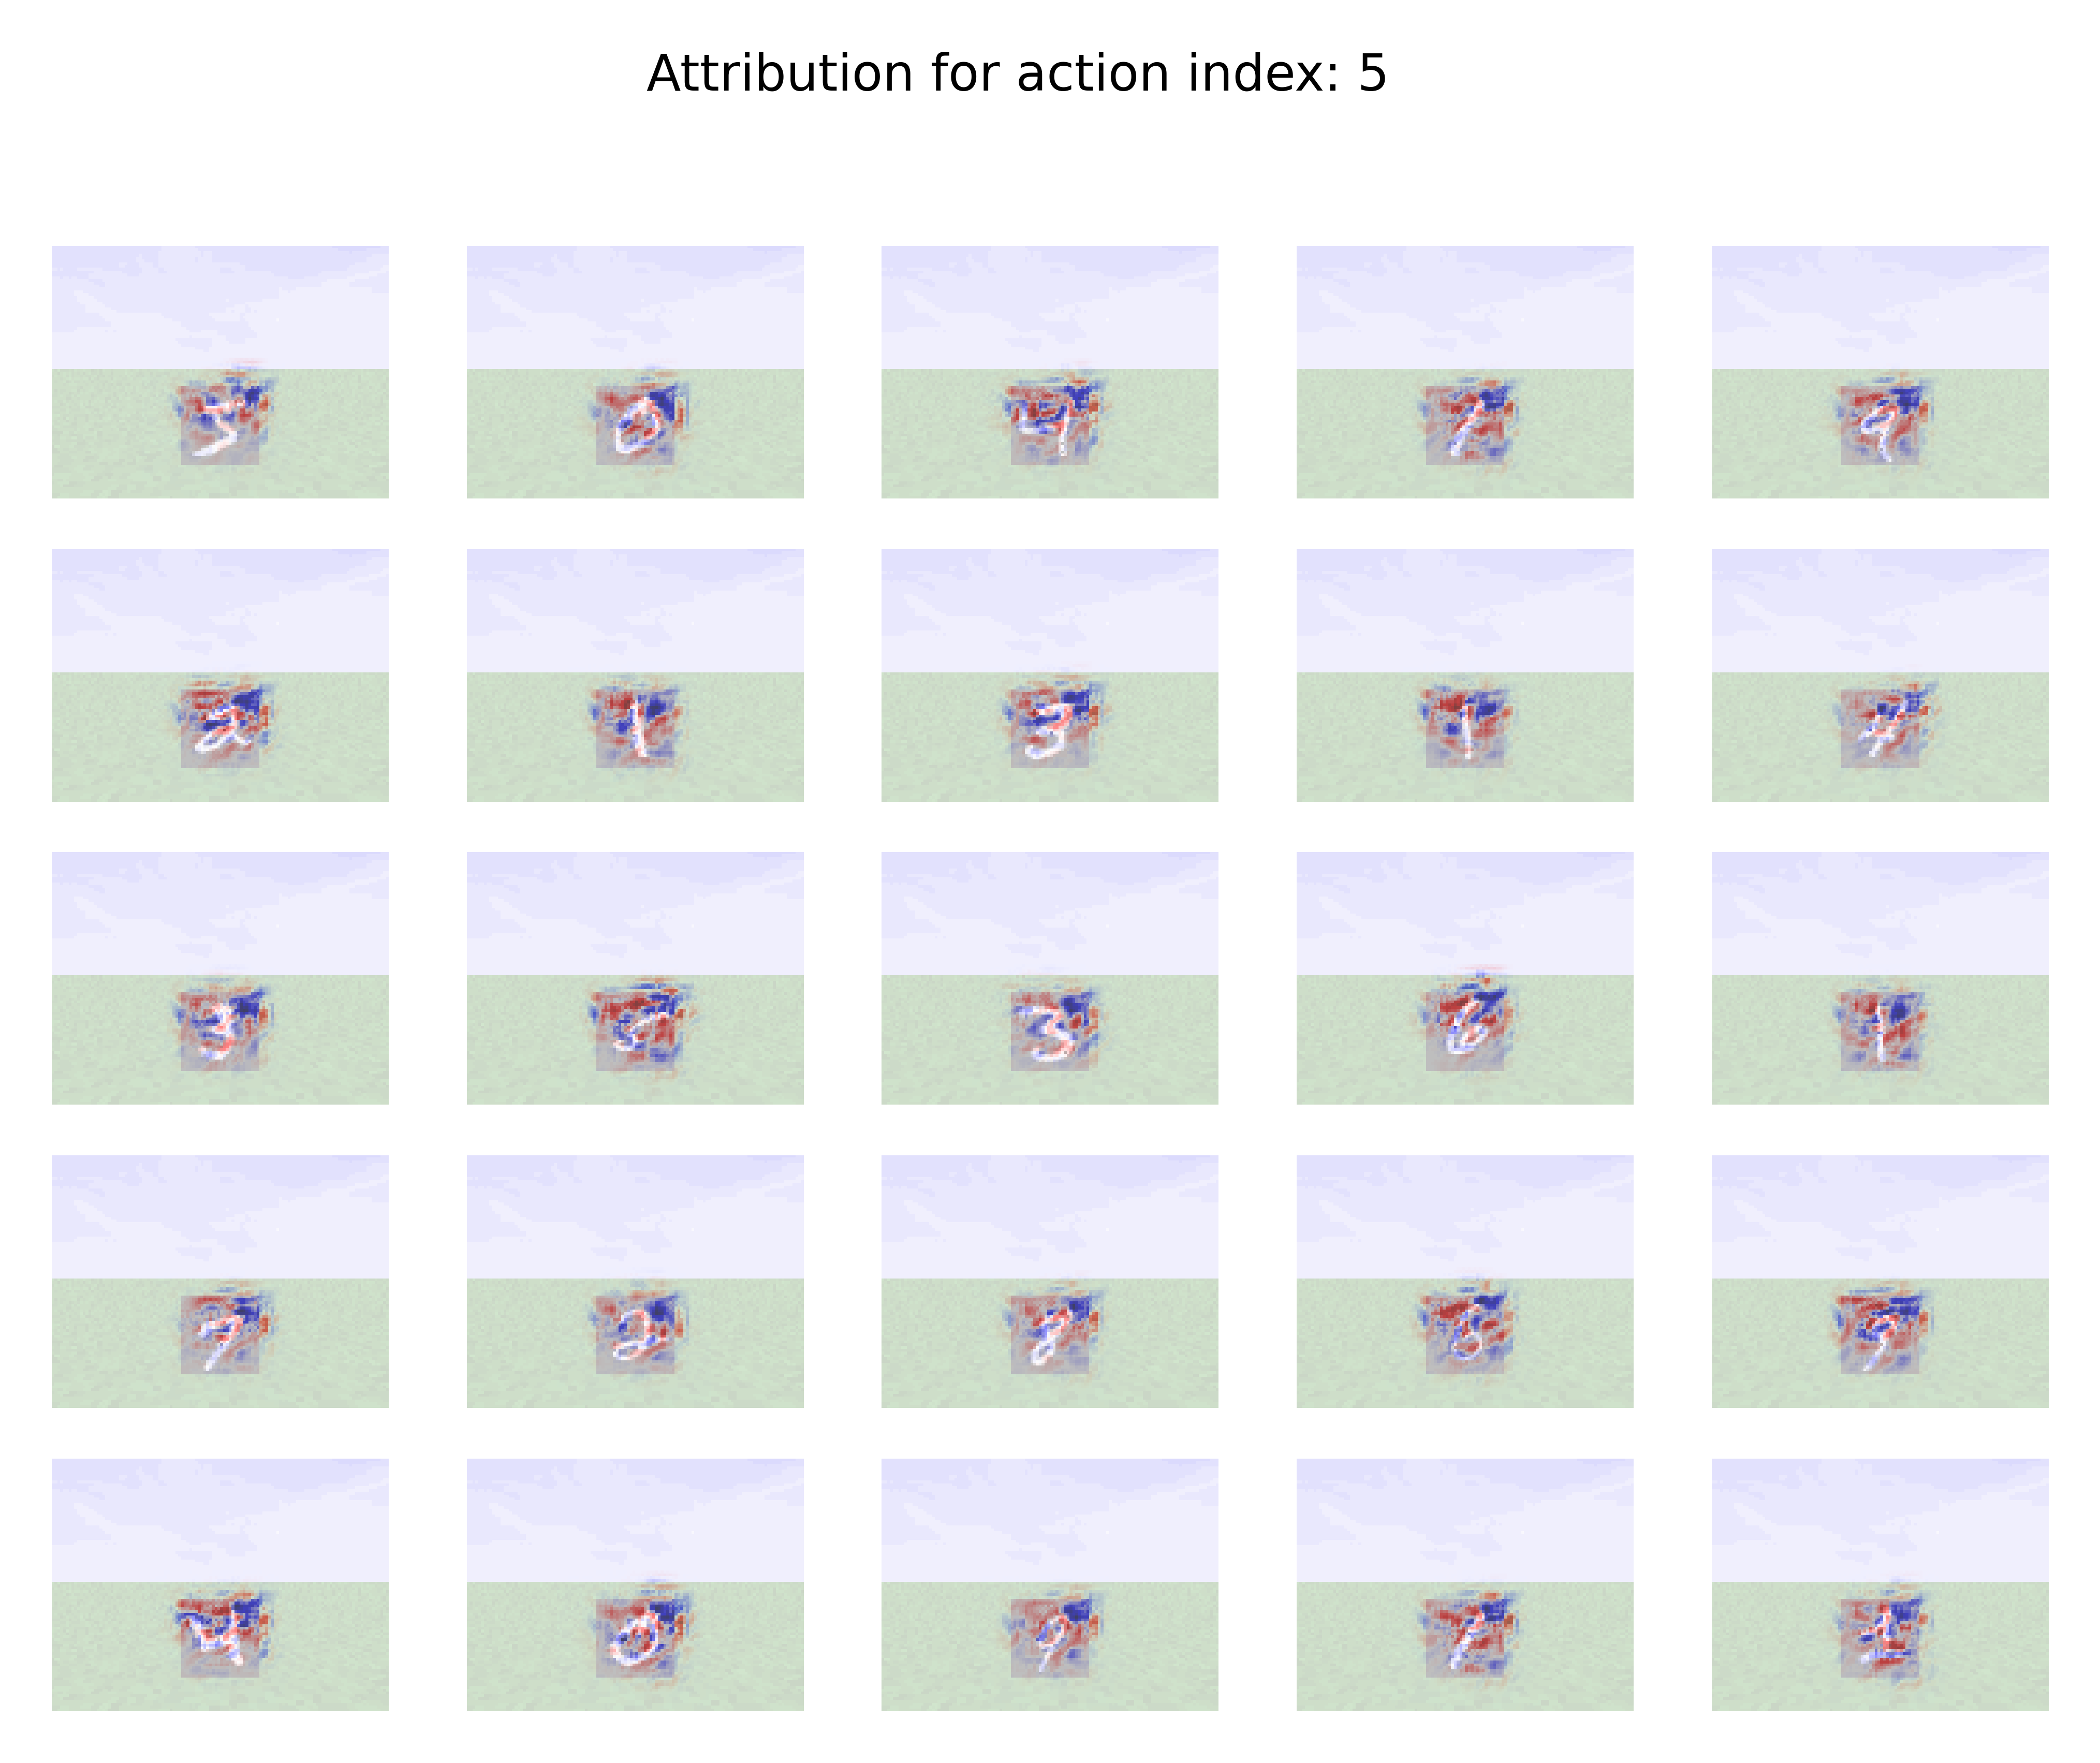

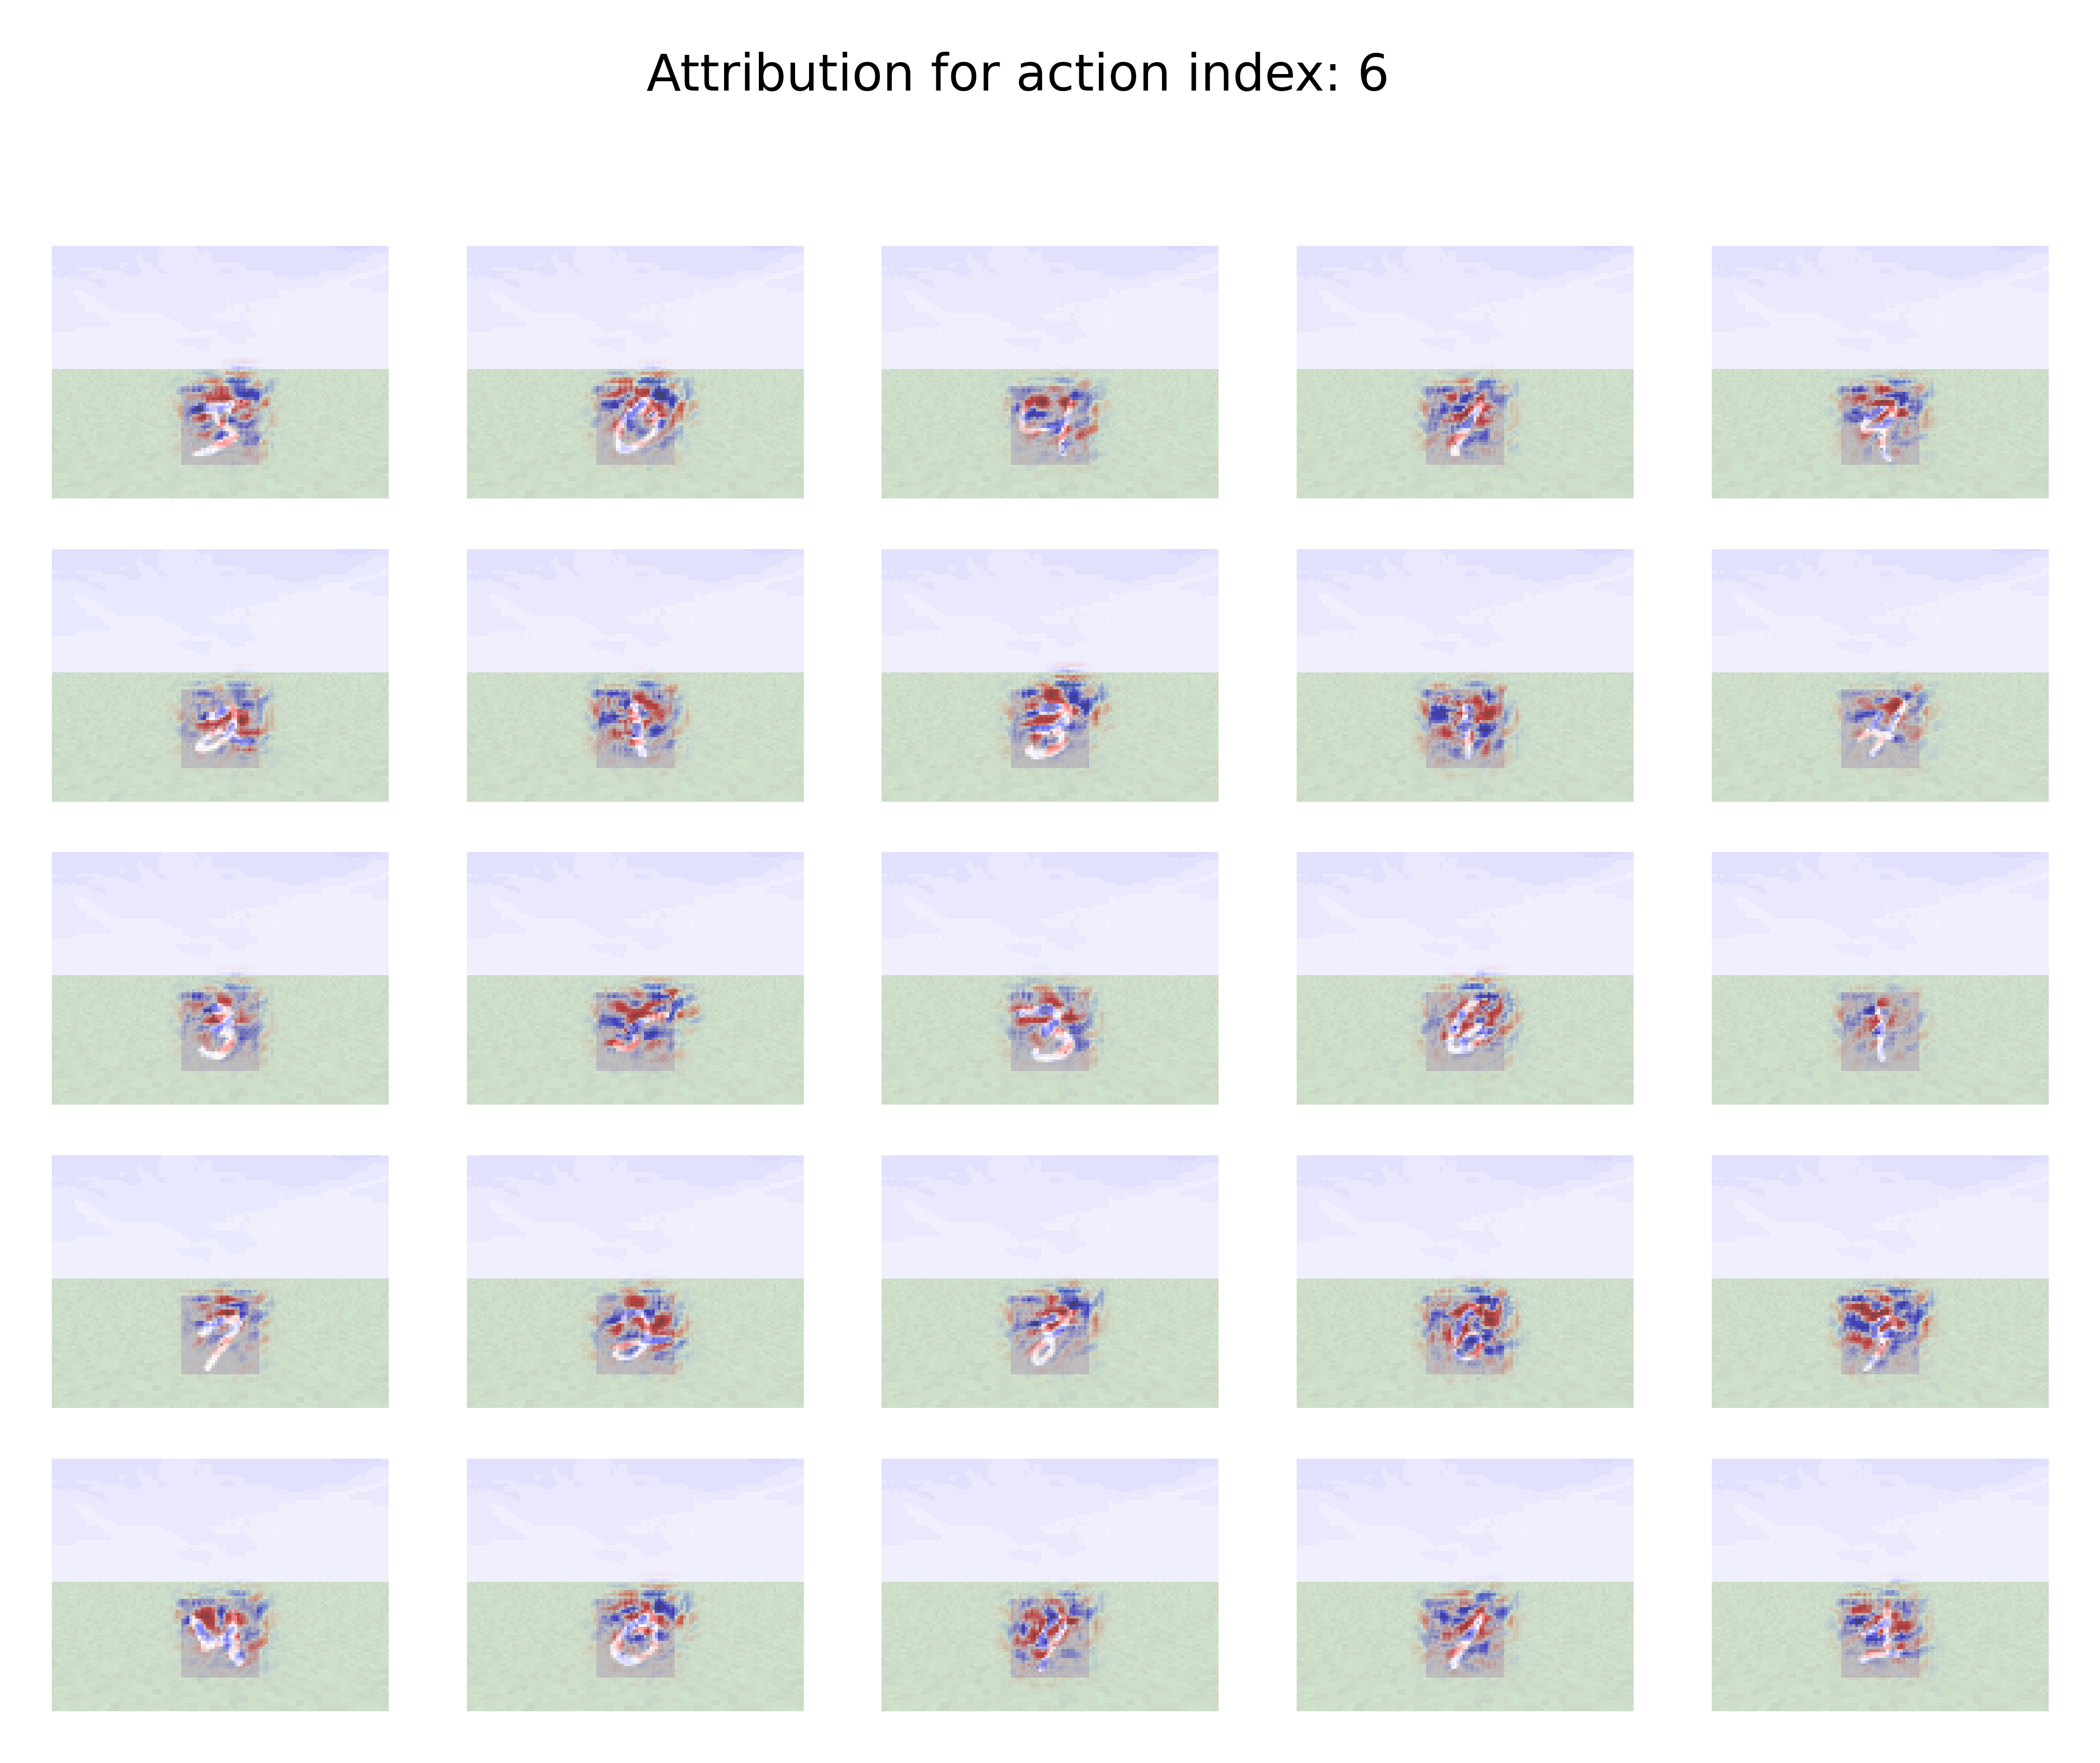

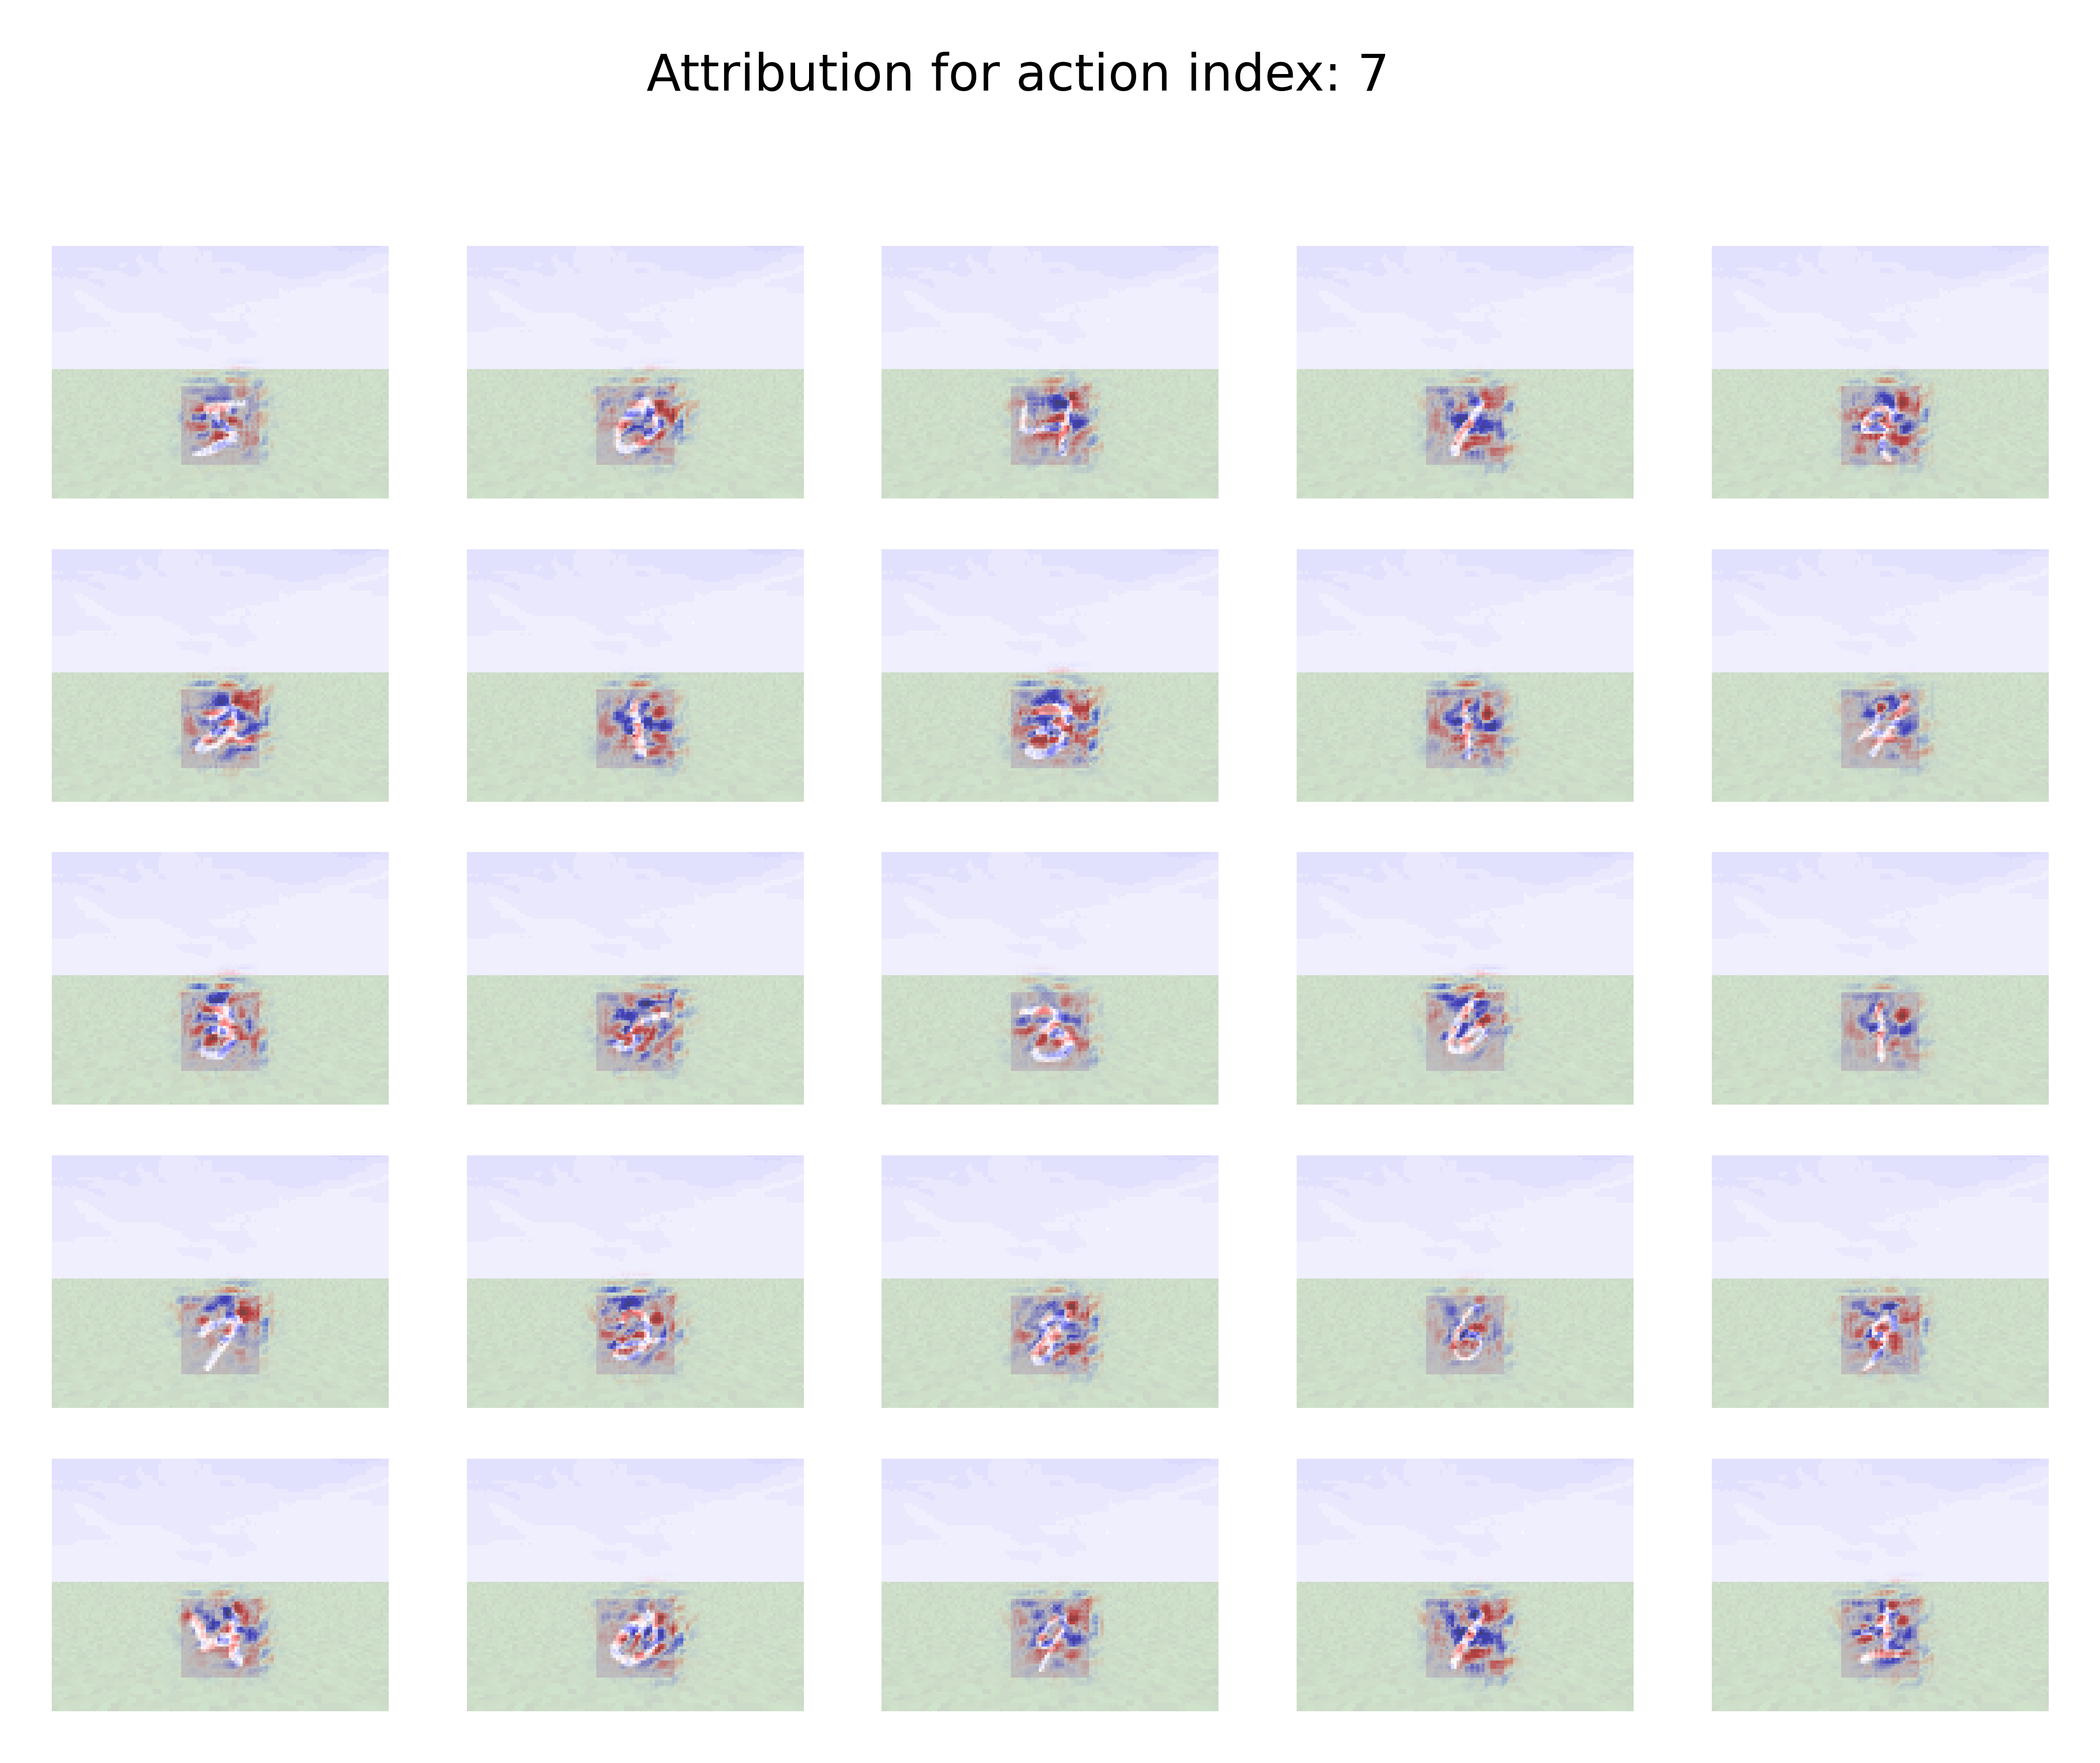

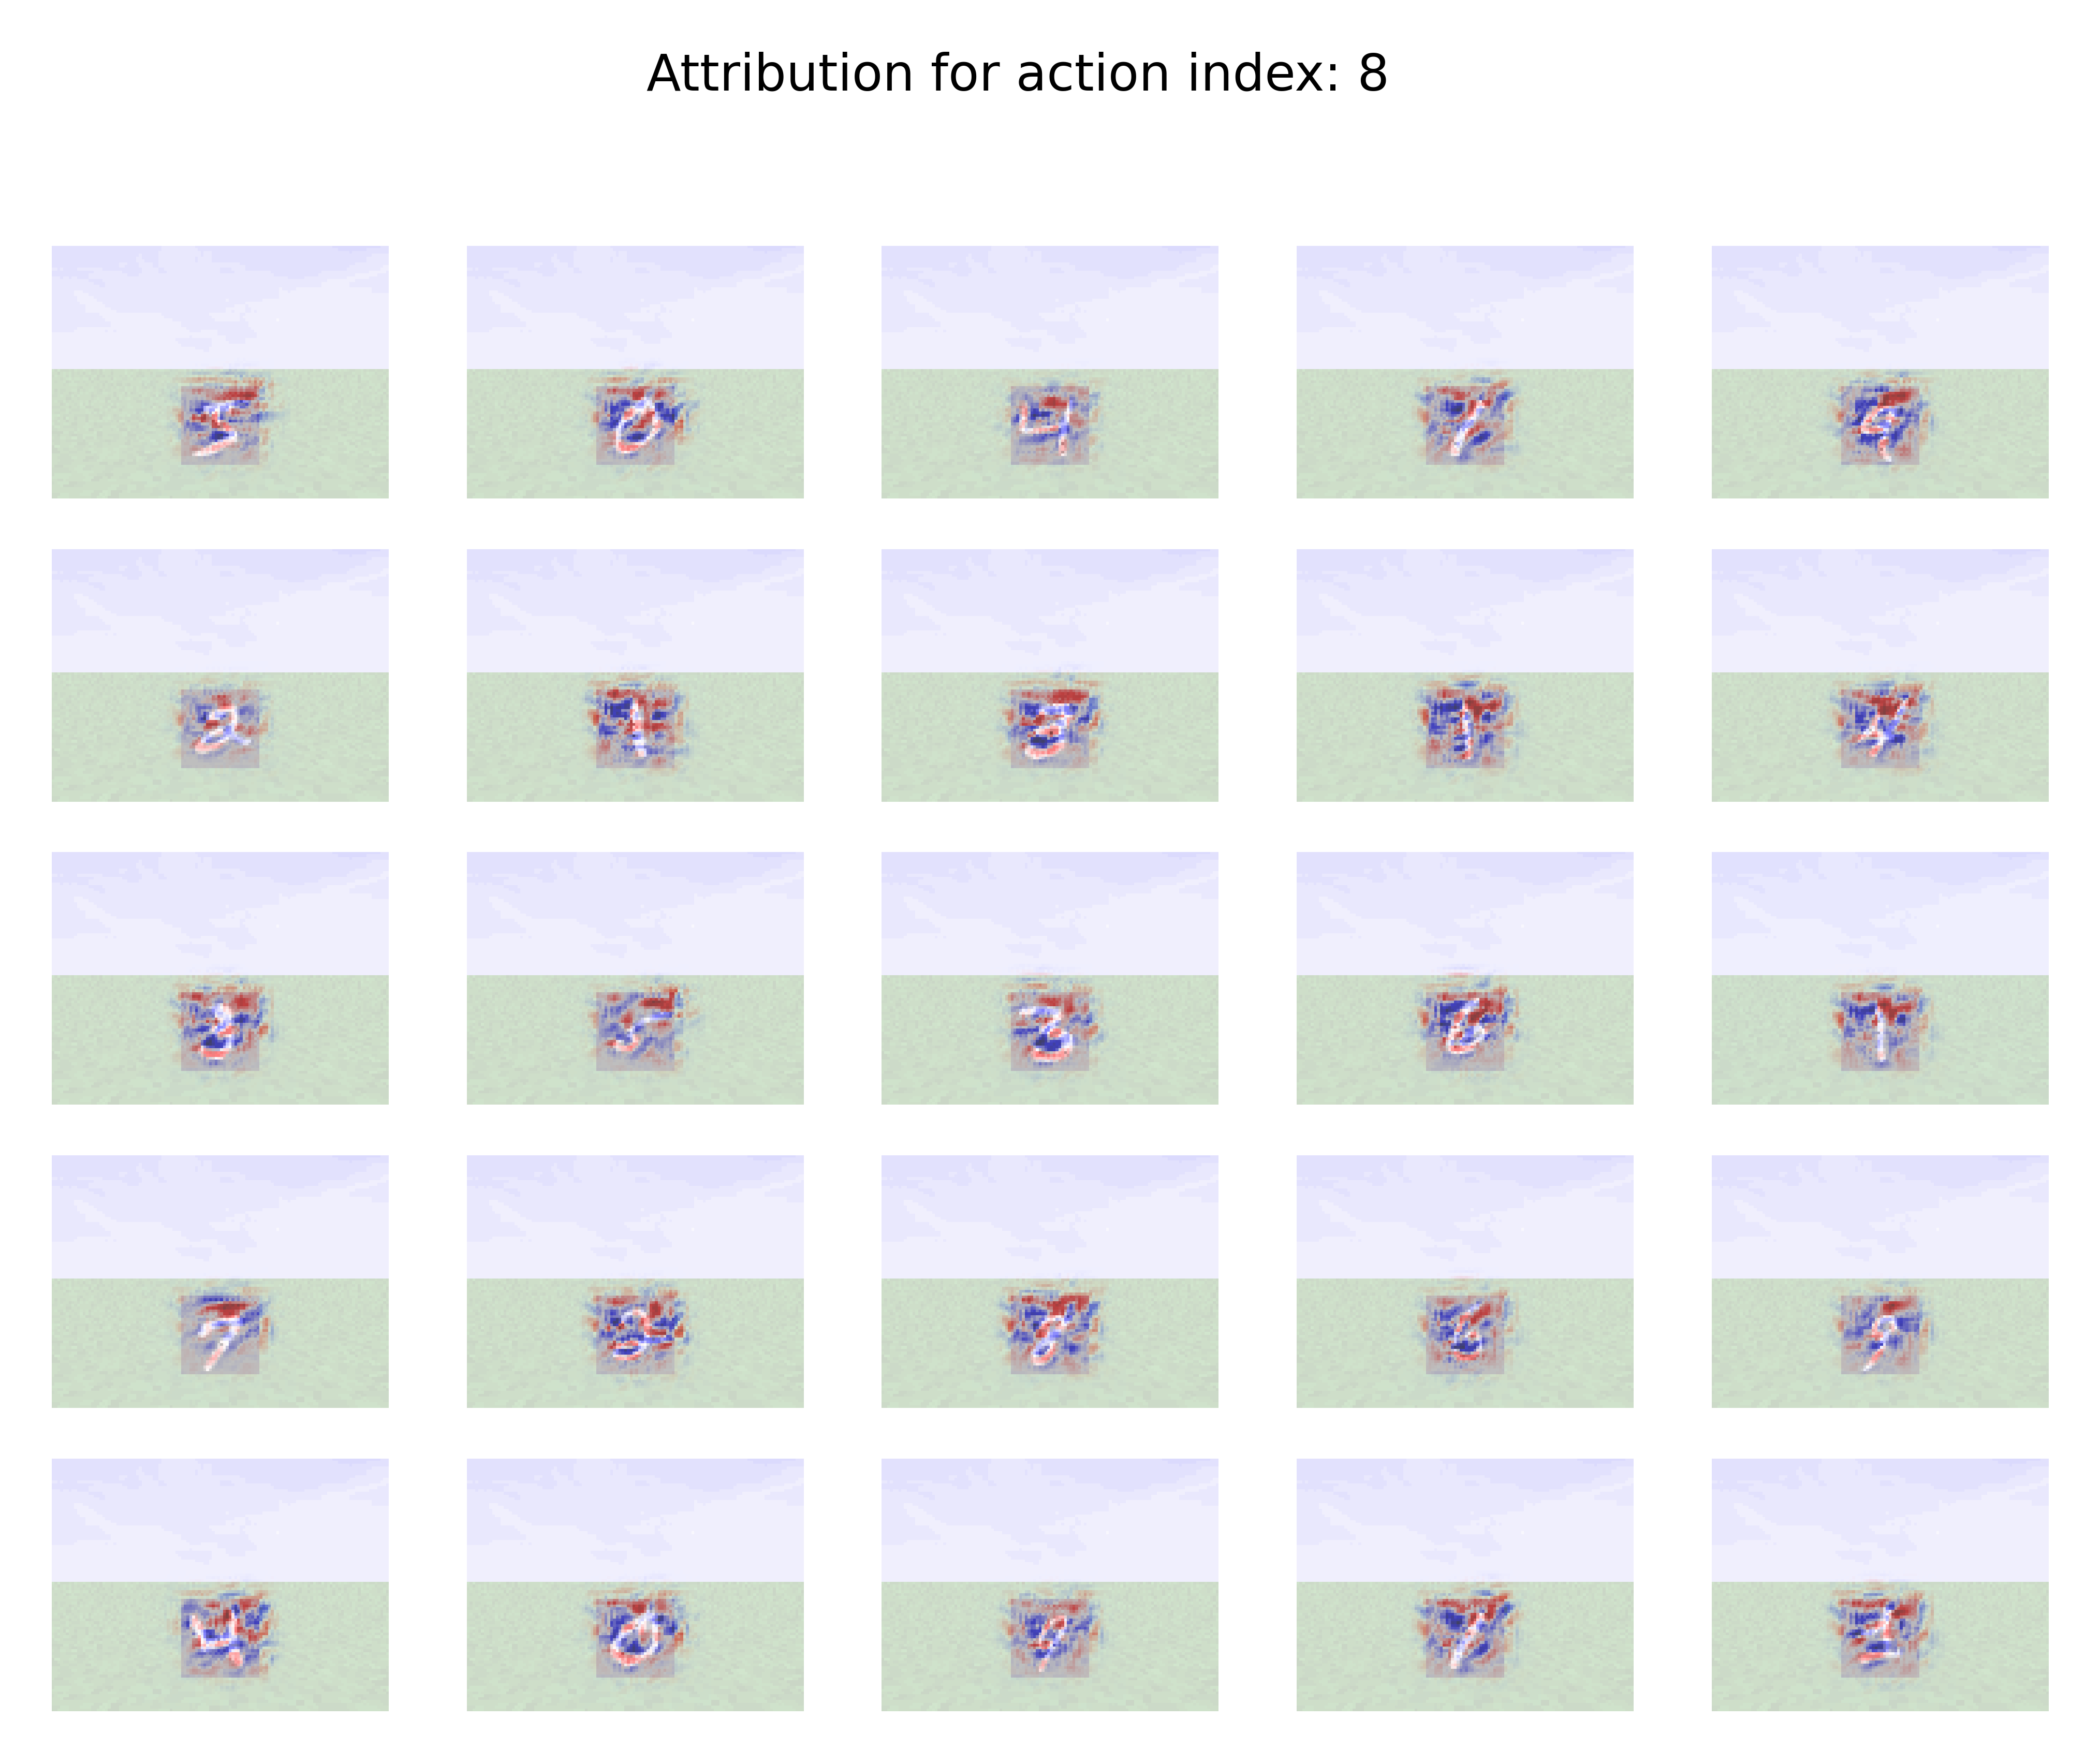

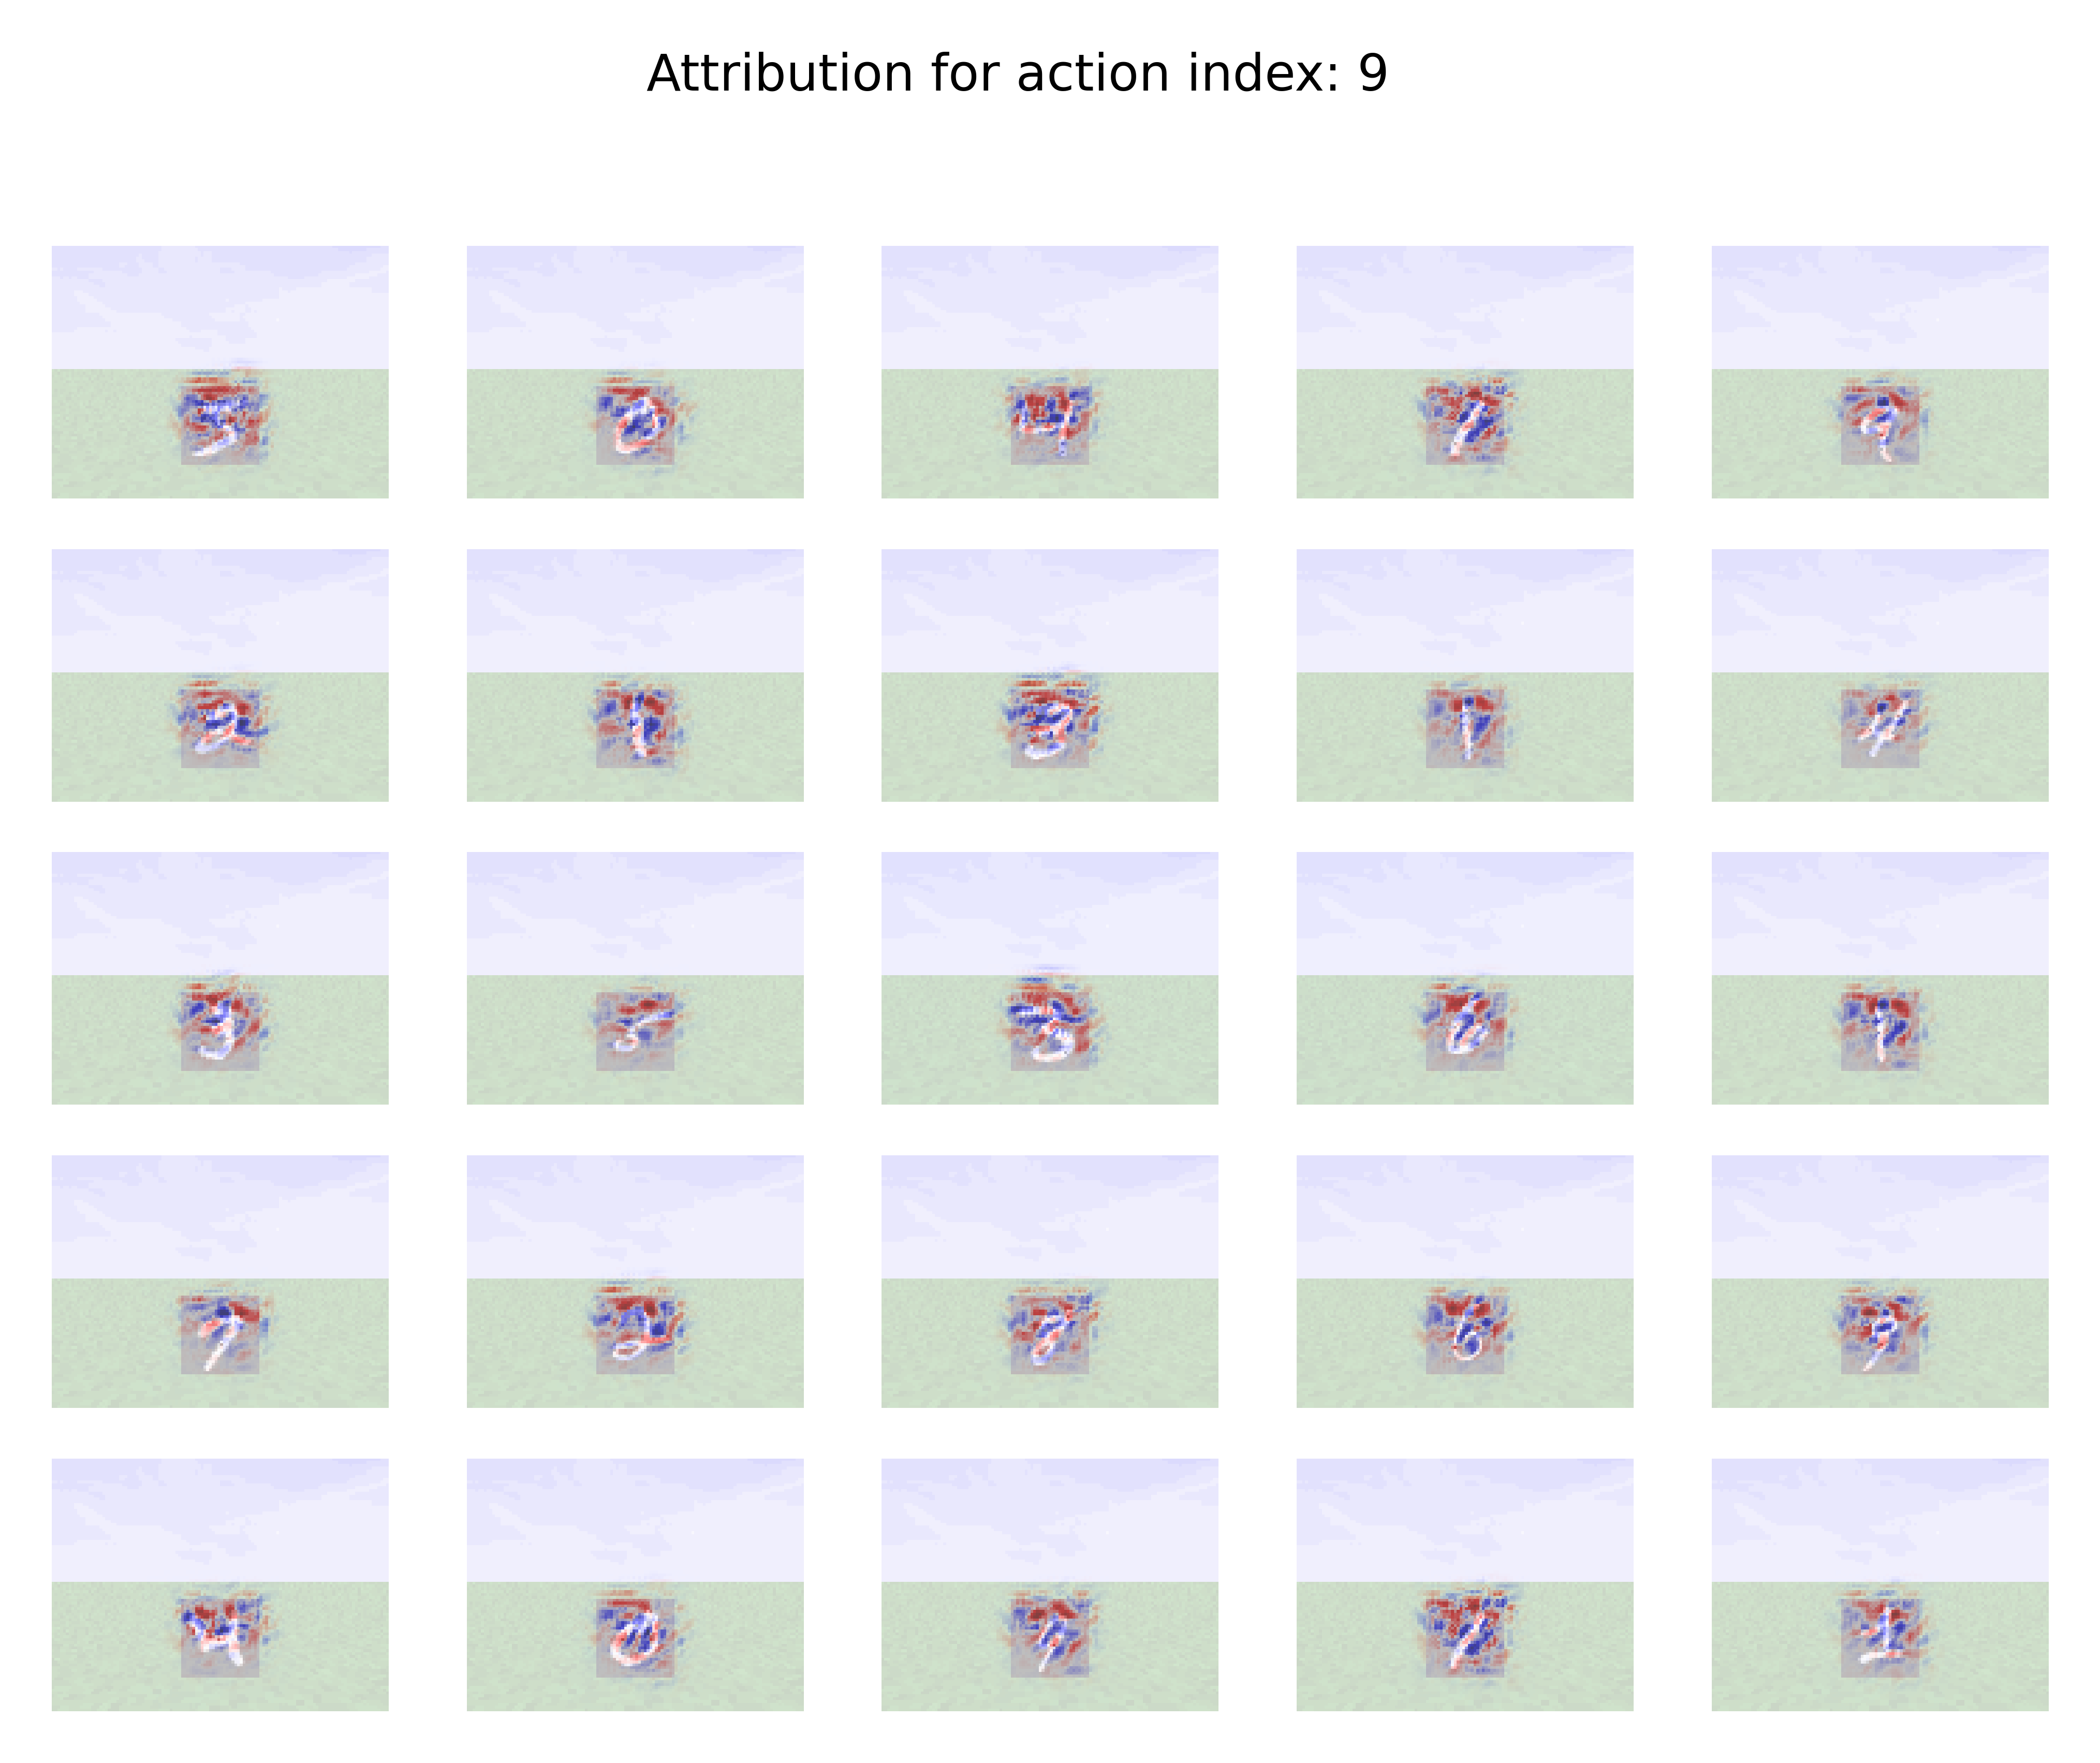

In [10]:
for class_index in range(10):
    plot_att_action(padded_ds, att_method=gbp, action_idx = class_index)